In [1]:
import os
import numpy as np
import pandas as pd
#from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D
#from keras.models import Sequential
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.metrics import categorical_accuracy

df = pd.read_csv('merged_rates/gsa_analysis.csv').drop('Unnamed: 0', axis=1).rename(columns={'responsibility':'functional_responsibility'})
df.head()

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,2022_2023_min,2023_2024_min,2024_2025_min,yoe_y.1,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change
0,Senior Program Manager,442.04,454.86,468.05,481.62,NaN,NaN,NaN,Bachelor's,The Senior Program Manager has overall account...,...,NaN,NaN,NaN,15,0.029002,0.028998,0.028993,NaN,NaN,NaN
1,Program Manager,389.42,400.71,412.33,424.29,NaN,NaN,NaN,Bachelor's,Program Managers plan and manage projects to c...,...,74.81,74.81,NaN,4,0.028992,0.028999,0.029006,NaN,NaN,NaN
2,Project Manager,252.85,260.18,267.73,275.49,NaN,NaN,NaN,Bachelor's,"The Project Manager manages, plans and coordin...",...,67.63,67.63,134.58,4,0.028990,0.029018,0.028984,NaN,NaN,NaN
3,Task Manager,190.81,196.34,202.03,207.89,NaN,NaN,NaN,Bachelor's,Task Managers apply their broad management ski...,...,NaN,NaN,NaN,4,0.028982,0.028980,0.029006,NaN,NaN,NaN
4,Subject Matter Expert 1,225.85,232.40,239.14,246.08,NaN,NaN,NaN,Bachelor's,The Subject Matter Expert 1 has industry exper...,...,NaN,NaN,NaN,10,0.029002,0.029002,0.029021,NaN,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   role                       628 non-null    object 
 1   2018_2019                  504 non-null    float64
 2   2019_2020                  600 non-null    float64
 3   2020_2021                  628 non-null    float64
 4   2021_2022                  584 non-null    float64
 5   2022_2023                  382 non-null    float64
 6   2023_2024                  273 non-null    float64
 7   2024_2025                  28 non-null     float64
 8   education                  628 non-null    object 
 9   functional_responsibility  628 non-null    object 
 10  yoe_x                      628 non-null    int64  
 11  company                    628 non-null    object 
 12  socio_economic             492 non-null    object 
 13  2018_2019_mean             518 non-null    float64

In [3]:
# Get rid of one Null row for role
df = df[df.role.notnull()]

## Preprocess data and remove stopwords

There are 'roles' located in the 'responsibility' column.  They must be removed to better match not on the roles themselves but on the responsibilities.  

One problem with the job responsibilities is that we noticed that several roles are cut off in the middle of the explanation, which may hinder optimized NLP analysis.

Also, the job responsibilities must be preprocessed for normalization, removing special characters, numbers, multiple spaces, shorten words with ing, etc.  This will increase the odds of having matching words within responsibilities for a better role match.

In [4]:
import re

# Take out role in functional responsibility
without_role = []

for r,fr in zip(df.role, df['functional_responsibility']):
    without_role.append(fr.replace(str(r),''))


# Preprocess data for normalization
preprocessed = []

for row in without_role:
    phrase = re.sub('[\n]+',' ', row) # Substitute new line characters for spaces
    phrase = phrase.lower() # Lowercase all values
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase) # remove special characters
    phrase = re.sub('ing', ' ', phrase) # remove ing
    phrase = re.sub(r'[0-9]+', ' ', phrase) # remove numbers
    phrase = re.sub(' +', ' ', phrase) # remove double spaces
    preprocessed.append(phrase)
    
    
# Assign new data to a column and strip spaces
df['responsibility'] = preprocessed
df['responsibility'] = df.responsibility.str.strip()
df.head(1)

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,2023_2024_min,2024_2025_min,yoe_y.1,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility
0,Senior Program Manager,442.04,454.86,468.05,481.62,NaN,NaN,NaN,Bachelor's,The Senior Program Manager has overall account...,...,NaN,NaN,15,0.029002,0.028998,0.028993,NaN,NaN,NaN,the has overall accountability for business so...


Contractions are shortened words, e.g., don’t and can’t. Expanding such words to “do not” and “can not” helps to standardize text.

In [5]:
# Try and think of ways to expand contractions
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Apply contraction
contracted = []
for row in df.responsibility:
    contracted.append(decontracted(row))
    
# reassign contraction
df['responsibility'] = contracted
df.head(1)

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,2023_2024_min,2024_2025_min,yoe_y.1,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility
0,Senior Program Manager,442.04,454.86,468.05,481.62,NaN,NaN,NaN,Bachelor's,The Senior Program Manager has overall account...,...,NaN,NaN,15,0.029002,0.028998,0.028993,NaN,NaN,NaN,the has overall accountability for business so...


Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document. Generally, the most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc.

In [6]:
# Encountering an error with nltk not being defined in order to download stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')

In [7]:
# Printed and copy stopwords instead
print(len(stopwords.words('english')),'\n', stopwords.words('english'))

179 
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'th

In [8]:
# Place stop words in list
my_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
                'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
                'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
                "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 
                'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
                'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 
                'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 
                'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 
                'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
                'through', 'during', 'before', 'after', 'above', 'below', 'to', 
                'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
                'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
                'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
                'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 
                'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
                "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 
                've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', 
                "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
                'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', 
                "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
                'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Create stopword removal function
def remove_mystopwords(sentence):
    text_tokens = sentence.split(" ")
    tokens_filtered= [word for word in text_tokens if not word in my_stopwords]
    return (" ").join(tokens_filtered)

# remove stopwords
df['responsibility'] = df.responsibility.apply(remove_mystopwords)
df['responsibility'] = df.responsibility.str.strip()
df.responsibility[:10]

0    overall accountability business solution progr...
1    plan manage projects control overall project s...
2    manages plans coordinates activities projects ...
3    apply broad management skills specialized func...
4    industry experience relevant subject matter in...
5    industry experience relevant subject matter in...
6    industry experience relevant subject matter in...
7    provides thought leadership related current fu...
8    provides thought leadership related current fu...
9    may develop run tests implement maintain opera...
Name: responsibility, dtype: object

Lemmatization is the process of converting a word to its base form, e.g., “caring” to “care”. We use spaCy’s lemmatizer to obtain the lemma, or base form, of the words. Sample code:

In [9]:
import spacy
nlp = spacy.load('en_core_web_sm') # load spacy model, can be "en_core_web_sm"

# Lemmatization example
text = """he kept eating while we are talking"""
doc = nlp(text)
mytokens = [word.lemma_ if word.lemma_ != "-PrON-" else word.lower_ for word in doc]
print(mytokens) 

['-PRON-', 'keep', 'eat', 'while', '-PRON-', 'be', 'talk']


In [10]:
# Apply lemmatization in order to get the base form of a word
lemmatized = []

for text in df['responsibility']:
    doc = nlp(text)
    # Lemmatizing each token
    mytokens = [word.lemma_ if word.lemma_ != "-PrON-" else word.lower_ for word in doc]
    join_list = (' ').join(mytokens) # Join list of words into a sentence
    lemmatized.append(join_list) # Append to a list
    
df['responsibility'] = lemmatized
df.responsibility[:10]

0    overall accountability business solution progr...
1    plan manage project control overall project sc...
2    manages plan coordinate activity project indiv...
3    apply broad management skill specialized funct...
4    industry experience relevant subject matter in...
5    industry experience relevant subject matter in...
6    industry experience relevant subject matter in...
7    provide think leadership relate current future...
8    provide think leadership relate current future...
9    may develop run test implement maintain operat...
Name: responsibility, dtype: object

___

After initial preprocessing, I've noticed that many of the different level roles have the same job responsibility which will hurt separating role levels.  This is only from the CIOSP3 data.

## Cosine Similarity

In [11]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sparse_dot_topn import awesome_cossim_topn


# Instaniate our lookup hash table
group_lookup = {}


# Write a function for cleaning strings and returning an array of ngrams
def ngrams_analyzer(string):
    string = re.sub(r'[,-./]', r'', string)
    ngrams = zip(*[string[i:] for i in range(5)])  # N-Gram length is 5
    return [''.join(ngram) for ngram in ngrams]


def find_group(row, col):
    # If either the row or the col string have already been given
    # a group, return that group. Otherwise return none
    if row in group_lookup:
        return group_lookup[row]
    elif col in group_lookup:
        return group_lookup[col]
    else:
        return None


def add_vals_to_lookup(group, row, col):
    # Once we know the group name, set it as the value
    # for both strings in the group_lookup
    group_lookup[row] = group
    group_lookup[col] = group


def add_pair_to_lookup(row, col):
    # in this function we'll add both the row and the col to the lookup
    group = find_group(row, col)  # first, see if one has already been added
    if group is not None:
        # if we already know the group, make sure both row and col are in lookup
        add_vals_to_lookup(group, row, col)
    else:
        # if we get here, we need to add a new group.
        # The name is arbitrary, so just make it the row
        add_vals_to_lookup(row, row, col)


# Construct vectorizer for building the TF-IDF matrix
vectorizer = TfidfVectorizer(analyzer=ngrams_analyzer)

# Grab the column you'd like to group, filter out duplicate values
# and make sure the values are Unicode
vals = df['role'].unique().astype('U')

# Build the matrix!!!
tf_idf_matrix = vectorizer.fit_transform(vals)

cosine_matrix = awesome_cossim_topn(tf_idf_matrix, tf_idf_matrix.transpose(), vals.size, 0.8)

# Build a coordinate matrix
coo_matrix = cosine_matrix.tocoo()

# for each row and column in coo_matrix
# if they're not the same string add them to the group lookup
for row, col in zip(coo_matrix.row, coo_matrix.col):
    if row != col:
        add_pair_to_lookup(vals[row], vals[col])

df['Group'] = df['role'].map(group_lookup).fillna(df['role'])

In [12]:
df.head()

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,2024_2025_min,yoe_y.1,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility,Group
0,Senior Program Manager,442.04,454.86,468.05,481.62,NaN,NaN,NaN,Bachelor's,The Senior Program Manager has overall account...,...,NaN,15,0.029002,0.028998,0.028993,NaN,NaN,NaN,overall accountability business solution progr...,Senior Program Manager
1,Program Manager,389.42,400.71,412.33,424.29,NaN,NaN,NaN,Bachelor's,Program Managers plan and manage projects to c...,...,NaN,4,0.028992,0.028999,0.029006,NaN,NaN,NaN,plan manage project control overall project sc...,Program Manager
2,Project Manager,252.85,260.18,267.73,275.49,NaN,NaN,NaN,Bachelor's,"The Project Manager manages, plans and coordin...",...,134.58,4,0.028990,0.029018,0.028984,NaN,NaN,NaN,manages plan coordinate activity project indiv...,Project Manager
3,Task Manager,190.81,196.34,202.03,207.89,NaN,NaN,NaN,Bachelor's,Task Managers apply their broad management ski...,...,NaN,4,0.028982,0.028980,0.029006,NaN,NaN,NaN,apply broad management skill specialized funct...,Task Manager
4,Subject Matter Expert 1,225.85,232.40,239.14,246.08,NaN,NaN,NaN,Bachelor's,The Subject Matter Expert 1 has industry exper...,...,NaN,10,0.029002,0.029002,0.029021,NaN,NaN,NaN,industry experience relevant subject matter in...,Subject Matter Expert 1


In [13]:
group_len = len(df.Group.value_counts())
df.Group.value_counts()

Project Manager                         18
Subject Matter Expert 1                 17
Technical Writer                        12
Software Engineer 1                     11
Database Administrator 1                11
                                        ..
Principal Cyber Security Specialist      1
IT Sr. Staff: Database Administrator     1
Subject Matter Expert- Journeyman        1
Web Tech Administrator                   1
Engineer 2                               1
Name: Group, Length: 333, dtype: int64

In [14]:
role_len = len(df.role.value_counts())
df.role.value_counts()

Project Manager                  8
Program Manager                  6
Technical Writer                 6
Project Director                 4
Subject Matter Expert IV         3
                                ..
Data Entry I                     1
Functional Specialist 2          1
Sr. QA Specialist                1
Data Processing Specialist II    1
Engineer 2                       1
Name: role, Length: 552, dtype: int64

In [15]:
# Percentage difference
per_diff = (abs(role_len - group_len)) / ((role_len + group_len) / 2)
per_diff

0.49491525423728816

In [16]:
# Percentage change
per_change = (group_len - role_len) / role_len
per_change

-0.3967391304347826

In [17]:
df[df.Group == 'Subject Matter Expert 1'].role.value_counts()

Subject Matter Expert I      3
Subject Matter Expert II     3
Subject Matter Expert III    3
Subject Matter Expert IV     3
Subject Matter Expert 1      1
Subject Matter Expert VI     1
Subject Matter Expert V      1
Subject Matter Expert 2      1
Subject Matter Expert 3      1
Name: role, dtype: int64

In [18]:
# See if many of these roles have the same responsibility in various companies
resp_check = df[df.Group == 'Subject Matter Expert 1']
resp_check.drop_duplicates(subset='company')
# Which they do

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,2024_2025_min,yoe_y.1,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility,Group
4,Subject Matter Expert 1,225.85,232.40,239.14,246.08,NaN,NaN,NaN,Bachelor's,The Subject Matter Expert 1 has industry exper...,...,NaN,10,0.029002,0.029002,0.029021,NaN,NaN,NaN,industry experience relevant subject matter in...,Subject Matter Expert 1
399,Subject Matter Expert IV,242.59,242.59,242.59,242.59,NaN,NaN,NaN,PhD,"Provides executive-level technical, managerial...",...,NaN,3,0.000000,0.000000,0.000000,NaN,NaN,NaN,provide executive level technical managerial a...,Subject Matter Expert 1
477,Subject Matter Expert IV,320.47,327.68,335.05,NaN,NaN,NaN,NaN,Bachelor's,Serve as subject matter expert in a functional...,...,NaN,3,0.022498,0.022491,NaN,NaN,NaN,NaN,serve subject matter expert functional technic...,Subject Matter Expert 1
605,Subject Matter Expert I,49.39,50.33,51.29,52.26,NaN,NaN,NaN,Associate's,Use Oracle-based system in a Client/Server env...,...,NaN,1,0.019032,0.019074,0.018912,NaN,NaN,NaN,use oracle base system client server environme...,Subject Matter Expert 1


In [19]:
# Construct vectorizer for building the TF-IDF matrix
vectorizer = TfidfVectorizer(analyzer=ngrams_analyzer)

# Grab the column you'd like to group, filter out duplicate values
# and make sure the values are Unicode
vals = df['responsibility'].unique().astype('U')

# Build the matrix!!!
tf_idf_matrix = vectorizer.fit_transform(vals)

cosine_matrix = awesome_cossim_topn(tf_idf_matrix, tf_idf_matrix.transpose(), vals.size, 0.8)

# Build a coordinate matrix
coo_matrix = cosine_matrix.tocoo()

# for each row and column in coo_matrix
# if they're not the same string add them to the group lookup
for row, col in zip(coo_matrix.row, coo_matrix.col):
    if row != col:
        add_pair_to_lookup(vals[row], vals[col])

df['Group_2'] = df['responsibility'].map(group_lookup).fillna(df['responsibility'])

In [20]:
resp_len = len(df.responsibility.value_counts())
df['responsibility'].value_counts()

provide expert independent service leadership specialize technical area provide expertise need basis task assignment provide expert advice assistance state art software hardware coordinate contractor management government personnel ensure problem properly define solution satisfy government requirement                                                                                                                                                                                                                                                                                                                                                                                                                                                     5
support information gather develop report document analytical studies research analyze write manage edit content communication channel product review work product quality completeness support research analysis business process design requirement gather test s

In [21]:
group2_len = len(df.Group_2.value_counts())
df.Group_2.value_counts()

provide analysis research national security infrastructure technology country geographic area biographic target vulnerability prepare assessment current threat trend base sophisticated collection research analysis classify open source information within earth observation service assist development analytical procedure meet chang requirement ensure maximum operational success collect datum -PRON- combination standard intelligence method business process perform datum collection analysis interpretation management duty prepare presentation reflect result data analysis work scientist technical expert design develop statistical analysis methodology maintain current knowledge relevant technology subject area participate special project require                                                                                                                                                                                                                                                             

In [22]:
# Percentage difference
per_diff = (abs(resp_len - group2_len)) / ((resp_len + group2_len) / 2)
per_diff

0.32075471698113206

In [23]:
# Percentage change
per_change = (group2_len - resp_len) / resp_len
per_change

-0.2764227642276423

In [24]:
phrase = 'organizes direct network installation site survey assess document current site network configuration user requirement design optimize network topology direct lead preparation engineer plan site installation technical design package develop installation schedule prepare site installation test report coordinate post installation operation maintenance support'

In [25]:
# Look into the roles more individually to see what the actual roles are
df[df.Group_2.str.contains(phrase)].role.value_counts()

Network Installation Technician           1
Senior Network Installation Technician    1
Name: role, dtype: int64

In [26]:
phrase = 'assist daily activity configuration operation system may mainframe mini client server base assist optimiz system operation resource utilization perform system capacity analysis plann provide assistance user access us business system commensurate experience education'

In [27]:
# Look into the roles more individually to see what the actual roles are
df[df.Group_2.str.contains(phrase)].role.value_counts()

Series([], Name: role, dtype: int64)

In [28]:
# See if many of these roles have the same responsibility in various companies
resp_check = df[df.Group_2 == phrase]
resp_check.drop_duplicates(subset='company')
# Which they do

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,yoe_y.1,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility,Group,Group_2


In [29]:
# Adjusted cosine cut off to 0.6

In [30]:
phrase = 'provide configuration management plann describe provision configuration identification change control configuration status account configuration audits regulate change process approve validate change incorporate product document relate software'

In [31]:
df[df.Group_2.str.contains(phrase)].role.value_counts()

Release and Configuration Manager - Mid.    1
Name: role, dtype: int64

In [32]:
# partial phrase
phrase = 'measurement technique'
# Note that the substring has to match a substring within the string, 2 words can't be in 2 different places
df[df.Group_2.str.contains(phrase)].role.value_counts()

Business Process Engineer 2               1
Business Process Engineer 1               1
Business Process Reengineering Analyst    1
Information Engineer 3                    1
Sr. Information Engineer                  1
Name: role, dtype: int64

In [33]:
# Create away to put in a series of words and have it return all responsibilities with it, then all roles
# Must turn haystack into df.role and loop through each one
import re

def find_string(needle, haystack):
    re_string = '.*'.join(needle)
    rEGEX = re.compile(re_string)
    return rEGEX.findall(haystack)

___
## Topic Modeling

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nltk
nltk.download('stopwords')
import pandas as pd
import re
import math

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dametreusv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# Tokenize text (split words into a list)
def split_line(text):
    # split the text
    words = text.split()
    return words

df['Tokenized'] = df.responsibility.apply(split_line)
df.head()

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility,Group,Group_2,Tokenized
0,Senior Program Manager,442.04,454.86,468.05,481.62,NaN,NaN,NaN,Bachelor's,The Senior Program Manager has overall account...,...,0.029002,0.028998,0.028993,NaN,NaN,NaN,overall accountability business solution progr...,Senior Program Manager,overall accountability business solution progr...,"[overall, accountability, business, solution, ..."
1,Program Manager,389.42,400.71,412.33,424.29,NaN,NaN,NaN,Bachelor's,Program Managers plan and manage projects to c...,...,0.028992,0.028999,0.029006,NaN,NaN,NaN,plan manage project control overall project sc...,Program Manager,plan manage project control overall project sc...,"[plan, manage, project, control, overall, proj..."
2,Project Manager,252.85,260.18,267.73,275.49,NaN,NaN,NaN,Bachelor's,"The Project Manager manages, plans and coordin...",...,0.028990,0.029018,0.028984,NaN,NaN,NaN,manages plan coordinate activity project indiv...,Project Manager,manages plan coordinate activity project indiv...,"[manages, plan, coordinate, activity, project,..."
3,Task Manager,190.81,196.34,202.03,207.89,NaN,NaN,NaN,Bachelor's,Task Managers apply their broad management ski...,...,0.028982,0.028980,0.029006,NaN,NaN,NaN,apply broad management skill specialized funct...,Task Manager,apply broad management skill specialized funct...,"[apply, broad, management, skill, specialized,..."
4,Subject Matter Expert 1,225.85,232.40,239.14,246.08,NaN,NaN,NaN,Bachelor's,The Subject Matter Expert 1 has industry exper...,...,0.029002,0.029002,0.029021,NaN,NaN,NaN,industry experience relevant subject matter in...,Subject Matter Expert 1,industry experience relevant subject matter in...,"[industry, experience, relevant, subject, matt..."


In [36]:
# Create bag of words and find most frequent words
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for responsibility in df.Tokenized for word in responsibility],10)

[('system', 891),
 ('software', 632),
 ('design', 630),
 ('technical', 486),
 ('project', 485),
 ('requirement', 449),
 ('management', 414),
 ('develop', 396),
 ('support', 383),
 ('program', 376)]

In [37]:
# Find number of topics


# build a dictionary where for each tweet, each word has its own id.
# We have 6882 tweets and 10893 words in the dictionary.
responsibility_dictionary = Dictionary(df.Tokenized)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
responsibility_corpus = [responsibility_dictionary.doc2bow(responsibility) for responsibility in df.Tokenized]

# compute coherence
responsibility_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(responsibility_corpus, num_topics = nb_topics, id2word = responsibility_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=responsibility_corpus, dictionary=responsibility_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    responsibility_coherence.append(coh)

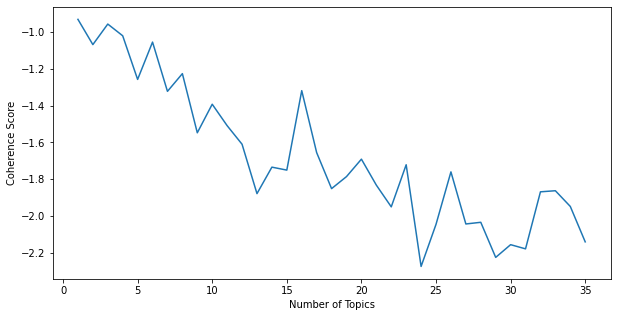

In [38]:
# visualize coherence (number of topics is where the plateau begins)
plt.figure(figsize=(10,5))
plt.plot(range(1,36),responsibility_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

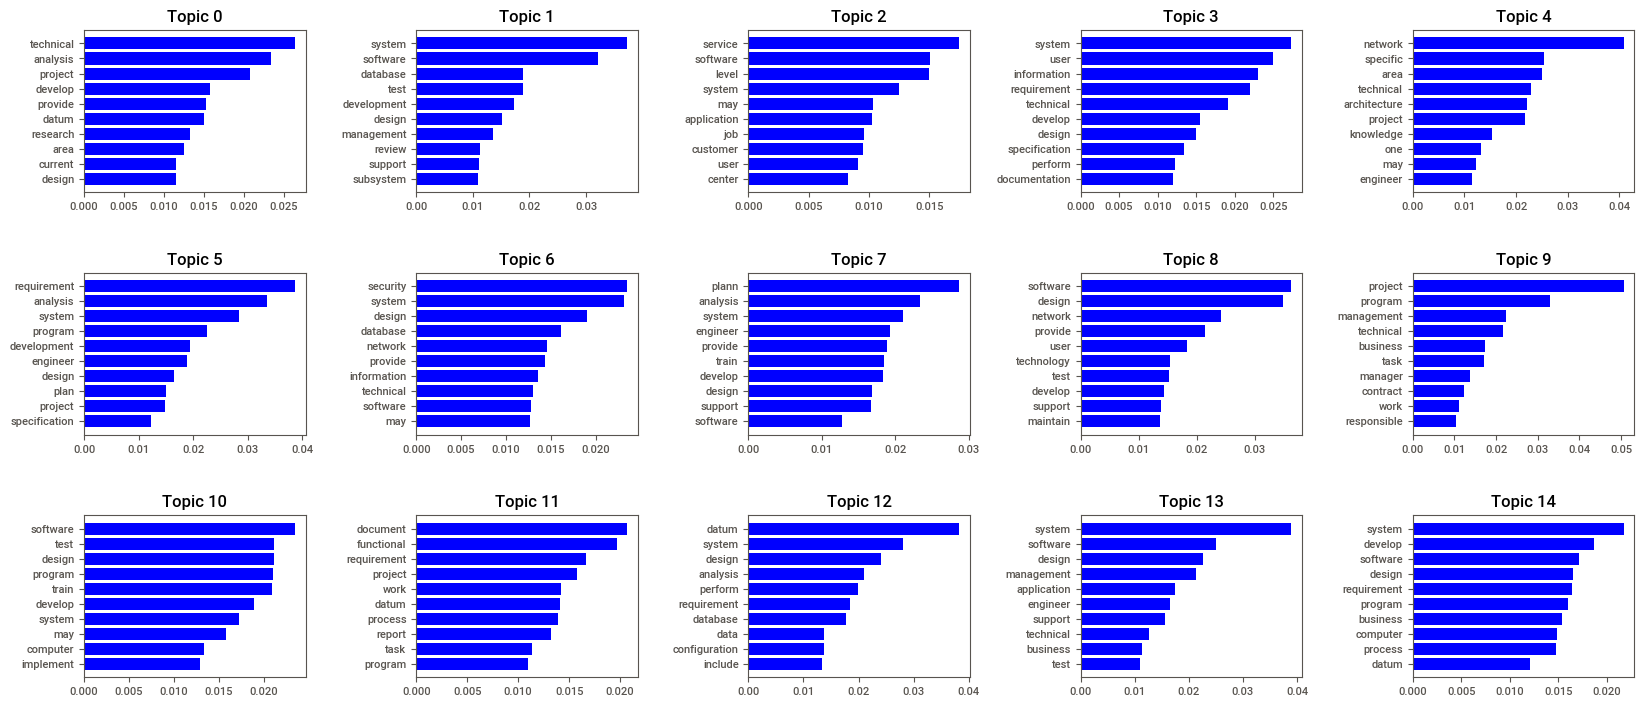

In [55]:
k = 15
responsibility_lda = LdaModel(responsibility_corpus, num_topics = k, id2word = responsibility_dictionary, passes=10)

def plot_top_words(lda=responsibility_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()

In [56]:
# partial phrase
phrase = 'implement database security'
# Note that the substring has to match a substring within the string, 2 words can't be in 2 different places
df[df.Group_2.str.contains(phrase)].role.value_counts()

Series([], Name: role, dtype: int64)

In [57]:
# partial phrase
phrase = 'infrastructure'
# Note that the substring has to match a substring within the string, 2 words can't be in 2 different places
df[df.Group_2.str.contains(phrase)].role.value_counts()

Technical Team Leader 1                     1
Geospatial Sr. Principal Analyst            1
Imagery Analyst                             1
Software Engineer                           1
Sr. Web Developer                           1
Imagery Sr. Analyst                         1
Imagery Principal Analyst                   1
Eng Principal: Website Designer             1
IT Project Manager 1                        1
Computer Security Specialist                1
Senior Software Engineer 1                  1
Software Engineer 2                         1
Network/Computer Support Specialist         1
Junior Software Engineer                    1
Geospatial Principal Analyst                1
Eng Senior: Website Designer                1
Technical Team Leader 2                     1
Senior Software Engineer 2                  1
Associate Software Engineer 2               1
Senior IT Project Manager 2                 1
Senior Software Engineer                    1
IT Project Manager 2              

In [58]:
# This is not good as well because we poses an 'OR' statement but just drops duplicates
phrase = 'implement database security'
role_search = split_line(phrase)

df2 = df[df.responsibility.str.contains('|'.join(role_search))].drop_duplicates('responsibility')
df2

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility,Group,Group_2,Tokenized
7,Technical Architect 1,190.81,196.34,202.03,207.89,NaN,NaN,NaN,Bachelor's,The Technical Architect 1 provides thought lea...,...,0.028982,0.028980,0.029006,NaN,NaN,NaN,provide think leadership relate current future...,Technical Architect 1,provide think leadership relate current future...,"[provide, think, leadership, relate, current, ..."
9,System Administrator 1,112.67,115.94,119.30,122.76,NaN,NaN,NaN,Bachelor's,"System Administrator 1s may develop, run tests...",...,0.029023,0.028981,0.029003,NaN,NaN,NaN,may develop run test implement maintain operat...,System Administrator 1,may develop run test implement maintain operat...,"[may, develop, run, test, implement, maintain,..."
10,System Administrator 2,164.32,169.09,173.99,179.04,NaN,NaN,NaN,Bachelor's,"System Administrator 2s may develop, run tests...",...,0.029029,0.028979,0.029025,NaN,NaN,NaN,may develop run test implement maintain operat...,System Administrator 1,may develop run test implement maintain operat...,"[may, develop, run, test, implement, maintain,..."
11,System Administrator 3,190.81,196.34,202.03,207.89,NaN,NaN,NaN,Bachelor's,"System Administrator 3s may develop, run tests...",...,0.028982,0.028980,0.029006,NaN,NaN,NaN,may develop run test implement maintain operat...,System Administrator 1,may develop run test implement maintain operat...,"[may, develop, run, test, implement, maintain,..."
12,Database Administrator 1,112.67,115.94,119.30,122.76,NaN,NaN,NaN,Bachelor's,Database Administrator 1 administers organizat...,...,0.029023,0.028981,0.029003,NaN,NaN,NaN,administers organization database us database ...,Database Administrator 1,administers organization database us database ...,"[administers, organization, database, us, data..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,Junior Technology Consultant,187.47,191.03,194.66,198.36,NaN,NaN,NaN,Bachelor's,Provides specialized analysis and solution dev...,...,0.018990,0.019002,0.019008,NaN,NaN,NaN,provide specialized analysis solution developm...,Technology Consultant,provide specialized analysis solution developm...,"[provide, specialized, analysis, solution, dev..."
622,Database Administrator,146.63,149.42,152.26,155.15,NaN,NaN,NaN,Bachelor's,Provides technical expertise and support in pl...,...,0.019027,0.019007,0.018981,NaN,NaN,NaN,provide technical expertise support plann acqu...,Database Administrator 1,provide technical expertise support plann acqu...,"[provide, technical, expertise, support, plann..."
623,Junior Database Administrator,113.46,115.61,117.81,120.05,NaN,NaN,NaN,Bachelor's,Independently or as part of the team provides ...,...,0.018949,0.019029,0.019014,NaN,NaN,NaN,independently part team provide technical expe...,Junior Database Administrator,provide technical expertise support plann acqu...,"[independently, part, team, provide, technical..."
624,Network Analyst,92.42,94.18,95.97,97.79,NaN,NaN,NaN,Bachelor's,"Responsible for site survey, acquisition, inst...",...,0.019043,0.019006,0.018964,NaN,NaN,NaN,responsible site survey acquisition installati...,Network Analyst,responsible site survey acquisition installati...,"[responsible, site, survey, acquisition, insta..."


In [59]:
phrase = 'implement test run'
role_search = split_line(phrase)

for tokenized in df.Tokenized:
    if all(item in tokenized for item in role_search):
        print(tokenized)

['may', 'develop', 'run', 'test', 'implement', 'maintain', 'operat', 'system', 'relate', 'software', 'establish', 'implement', 'standard', 'computer', 'operation', 'compatibility', 'hardware', 'software', 'accord', 'specification', 'parameter', 'individual', 'troubleshoot', 'resolve', 'software', 'operat', 'system', 'network', 'problem', 'schedule', 'perform', 'monitor', 'system', 'backup', 'necessary', 'perform', 'datum', 'recovery', 'level', 'perform', 'routine', 'aspect', 'position', 'supervise', 'high', 'level']
['may', 'develop', 'run', 'test', 'implement', 'maintain', 'operat', 'system', 'relate', 'software', 'establish', 'implement', 'standard', 'computer', 'operation', 'compatibility', 'hardware', 'software', 'accord', 'specification', 'parameter', 'individual', 'troubleshoot', 'resolve', 'software', 'operat', 'system', 'network', 'problem', 'schedule', 'perform', 'monitor', 'system', 'backup', 'necessary', 'perform', 'datum', 'recovery', 'level', 'perform', 'varied', 'difficul

In [60]:
phrase = 'implement test run'
role_search = split_line(phrase)

for responsibility in df.responsibility:
    if all(item in responsibility for item in role_search):
        print(responsibility)

may develop run test implement maintain operat system relate software establish implement standard computer operation compatibility hardware software accord specification parameter individual troubleshoot resolve software operat system network problem schedule perform monitor system backup necessary perform datum recovery level perform routine aspect position supervise high level
may develop run test implement maintain operat system relate software establish implement standard computer operation compatibility hardware software accord specification parameter individual troubleshoot resolve software operat system network problem schedule perform monitor system backup necessary perform datum recovery level perform varied difficult task compare level yet less autonomy level
may develop run test implement maintain operat system relate software establish implement standard computer operation compatibility hardware software accord specification parameter individual troubleshoot resolve softwa

In [61]:
phrase = 'implement test run'
role_search = split_line(phrase)

roles = []
for responsibility in df.responsibility:
    if all(item in responsibility for item in role_search):
        roles.append(responsibility)
        
df2 = df[df.responsibility.str.contains('|'.join(roles))].drop_duplicates('responsibility')
df2

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility,Group,Group_2,Tokenized
9,System Administrator 1,112.67,115.94,119.30,122.76,NaN,NaN,NaN,Bachelor's,"System Administrator 1s may develop, run tests...",...,0.029023,0.028981,0.029003,NaN,NaN,NaN,may develop run test implement maintain operat...,System Administrator 1,may develop run test implement maintain operat...,"[may, develop, run, test, implement, maintain,..."
10,System Administrator 2,164.32,169.09,173.99,179.04,NaN,NaN,NaN,Bachelor's,"System Administrator 2s may develop, run tests...",...,0.029029,0.028979,0.029025,NaN,NaN,NaN,may develop run test implement maintain operat...,System Administrator 1,may develop run test implement maintain operat...,"[may, develop, run, test, implement, maintain,..."
11,System Administrator 3,190.81,196.34,202.03,207.89,NaN,NaN,NaN,Bachelor's,"System Administrator 3s may develop, run tests...",...,0.028982,0.028980,0.029006,NaN,NaN,NaN,may develop run test implement maintain operat...,System Administrator 1,may develop run test implement maintain operat...,"[may, develop, run, test, implement, maintain,..."


In [62]:
phrase = 'analyze system'
role_search = split_line(phrase)

roles = []
for responsibility in df.responsibility:
    if all(item in responsibility for item in role_search):
        roles.append(responsibility)
        
df2 = df[df.responsibility.str.contains('|'.join(roles))].drop_duplicates('responsibility')
df2

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility,Group,Group_2,Tokenized
26,Help Desk Specialist,77.36,79.60,81.91,84.29,NaN,NaN,NaN,Associate's,The Help Desk Specialist analyzes problems and...,...,0.028956,0.029020,0.029056,NaN,NaN,NaN,analyze problem provide technical assistance s...,Help Desk Specialist,analyze problem provide technical assistance s...,"[analyze, problem, provide, technical, assista..."
35,Program Analyst,111.99,115.24,118.58,122.02,NaN,NaN,NaN,Bachelor's,The Program Analyst analyzes and critiques com...,...,0.029020,0.028983,0.029010,NaN,NaN,NaN,analyzes critique computer program system deve...,Program Analyst,analyzes critique computer program system deve...,"[analyzes, critique, computer, program, system..."
48,Application Systems Analyst,165.39,170.19,175.13,180.21,NaN,NaN,NaN,Bachelor's,The Application Systems Analyst may oversee th...,...,0.029022,0.029026,0.029007,NaN,NaN,NaN,may oversee implementation require hardware so...,Application Systems Analyst,may oversee implementation require hardware so...,"[may, oversee, implementation, require, hardwa..."
52,Business Analyst 1,112.67,115.94,119.30,122.76,NaN,NaN,NaN,Bachelor's,The Business Analyst 1 may provide knowledge i...,...,0.029023,0.028981,0.029003,NaN,NaN,NaN,may provide knowledge business process system ...,Business Analyst 1,may provide knowledge business process system ...,"[may, provide, knowledge, business, process, s..."
53,Business Analyst 2,164.32,169.09,173.99,179.04,NaN,NaN,NaN,Bachelor's,The Business Analyst 2 may provide knowledge i...,...,0.029029,0.028979,0.029025,NaN,NaN,NaN,may provide knowledge business process system ...,Business Analyst 1,may provide knowledge business process system ...,"[may, provide, knowledge, business, process, s..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,Senior Application Engineer,NaN,79.80,79.80,79.80,79.80,79.80,NaN,Bachelor's,Analyzes and studies complex system requiremen...,...,NaN,0.000000,0.000000,0.0,0.0,NaN,analyzes study complex system requirement desi...,Senior Application Engineer,analyzes study complex system requirement desi...,"[analyzes, study, complex, system, requirement..."
576,Applications Engineer,NaN,9.82,9.82,9.82,9.82,9.82,NaN,Bachelor's,Analyzes and studies complex system requiremen...,...,NaN,0.000000,0.000000,0.0,0.0,NaN,analyzes study complex system requirement prep...,Applications Engineer,analyzes study complex system requirement desi...,"[analyzes, study, complex, system, requirement..."
586,Computer Scientist,NaN,138.84,138.84,138.84,138.84,138.84,NaN,Bachelor's,Acts as a senior consultant in complex or miss...,...,NaN,0.000000,0.000000,0.0,0.0,NaN,act senior consultant complex mission critical...,Computer Scientist,act senior consultant complex mission critical...,"[act, senior, consultant, complex, mission, cr..."
593,Senior Application Engineer,126.75,129.16,131.62,134.12,NaN,NaN,NaN,Bachelor's,Analyzes and studies complex system requiremen...,...,0.019014,0.019046,0.018994,NaN,NaN,NaN,analyzes study complex system requirement desi...,Senior Application Engineer,analyzes study complex system requirement desi...,"[analyzes, study, complex, system, requirement..."


In [63]:
df2.role.value_counts()

Senior Application Engineer            2
Sr. Software Engineer                  2
Web Developer 1                        1
Network Engineer                       1
Communications Engineer                1
                                      ..
Telecommunications Analyst             1
Legacy System Analyst                  1
Information Engineer 2                 1
Systems & Help Desk Administrator 2    1
Systems Analyst I                      1
Name: role, Length: 68, dtype: int64

In [64]:
df2.company.value_counts()

General Dynamics Information Technology    25
Citizant                                   10
Gunnison Consulting                         7
Accenture Federal Services                  6
Harmonia Software Engineering Solutions     6
Lockheed Martin                             5
1 Source Consulting                         4
Eidos Technologies                          3
PSI International                           2
Newport Hall                                1
ICF Incorporated                            1
Name: company, dtype: int64

In [65]:
df2.responsibility.nunique()

70

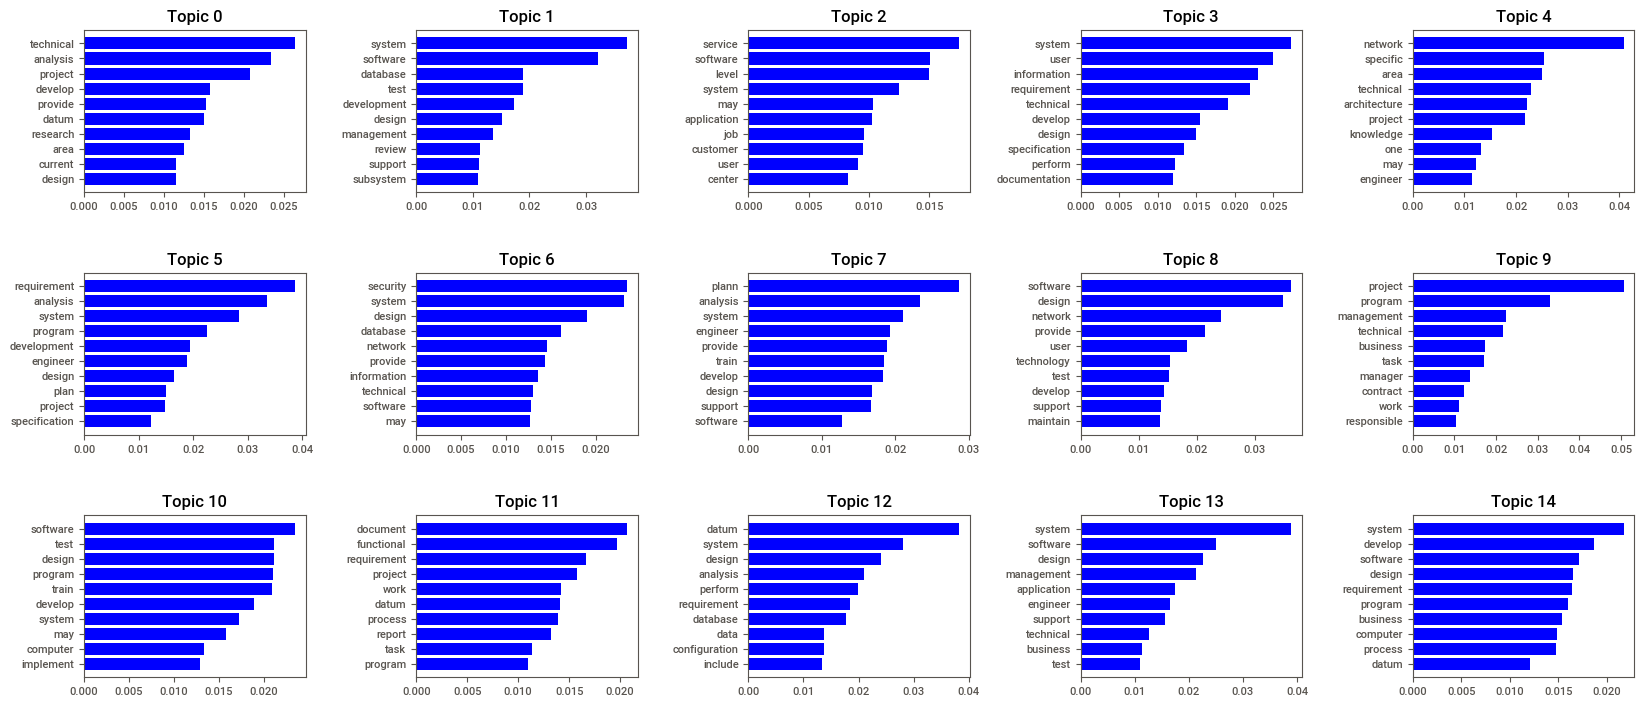

In [66]:
plot_top_words()

In [67]:
def find_role(phrase):
    global df2
    role_search = split_line(phrase)
    
    roles = []
    for responsibility in df.responsibility:
        if all(item in responsibility for item in role_search):
            roles.append(responsibility)
        
    df2 = df[df.responsibility.str.contains('|'.join(roles))].drop_duplicates('responsibility')
    df2 = df2.drop(['Group', 'Group_2', 'Tokenized'], axis=1)
    
    import sweetviz as sv

    my_report = sv.analyze(df2)
    # my_report.show_html() # Default arguments will generate to "SWEETVIZ_rEPOrT.html"
    return my_report.show_notebook()
    

In [68]:
df[df.company == 'Gunnison Consulting']

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility,Group,Group_2,Tokenized
340,Computer Specialist I,68.19,69.89,71.64,73.43,NaN,NaN,NaN,HS,Requires technical research and writing skills...,...,0.024930,0.025039,0.024986,NaN,NaN,NaN,require technical research writ skill provide ...,Computer Specialist I,require technical research writ skill provide ...,"[require, technical, research, writ, skill, pr..."
341,Computer Specialist I,68.19,69.89,71.64,73.43,NaN,NaN,NaN,Bachelor's,Requires technical research and writing skills...,...,0.024930,0.025039,0.024986,NaN,NaN,NaN,require technical research writ skill provide ...,Computer Specialist I,require technical research writ skill provide ...,"[require, technical, research, writ, skill, pr..."
342,Computer Specialist II,83.04,85.12,87.24,89.42,NaN,NaN,NaN,Bachelor's,Must have technical research and writing skill...,...,0.025048,0.024906,0.024989,NaN,NaN,NaN,must technical research writ skill moderate pr...,Computer Specialist I,must technical research writ skill moderate pr...,"[must, technical, research, writ, skill, moder..."
343,Expert Advisor,265.99,272.64,279.47,286.45,NaN,NaN,NaN,Bachelor's,Progressive and relevant experience in a speci...,...,0.025001,0.025051,0.024976,NaN,NaN,NaN,progressive relevant experience specific infor...,Expert Advisor,progressive relevant experience specific infor...,"[progressive, relevant, experience, specific, ..."
344,Expert Advisor,265.99,272.64,279.47,286.45,NaN,NaN,NaN,Master's,Progressive and relevant experience in a speci...,...,0.025001,0.025051,0.024976,NaN,NaN,NaN,progressive relevant experience specific infor...,Expert Advisor,progressive relevant experience specific infor...,"[progressive, relevant, experience, specific, ..."
345,Expert Advisor,265.99,272.64,279.47,286.45,NaN,NaN,NaN,PhD,Progressive and relevant experience in a speci...,...,0.025001,0.025051,0.024976,NaN,NaN,NaN,progressive relevant experience specific infor...,Expert Advisor,progressive relevant experience specific infor...,"[progressive, relevant, experience, specific, ..."
346,Facilitator,195.79,200.69,205.70,210.84,NaN,NaN,NaN,Bachelor's,Specific experience leading cross-functional t...,...,0.025027,0.024964,0.024988,NaN,NaN,NaN,specific experience lead cross functional team...,Facilitator,specific experience lead cross functional team...,"[specific, experience, lead, cross, functional..."
347,Facilitator,195.79,200.69,205.70,210.84,NaN,NaN,NaN,Master's,Specific experience leading cross-functional t...,...,0.025027,0.024964,0.024988,NaN,NaN,NaN,specific experience lead cross functional team...,Facilitator,specific experience lead cross functional team...,"[specific, experience, lead, cross, functional..."
348,Programmer/Analyst I,63.19,64.78,66.40,68.06,NaN,NaN,NaN,HS,Experience in applicable editors and programmi...,...,0.025162,0.025008,0.025000,NaN,NaN,NaN,experience applicable editor programm language...,Programmer/Analyst I,experience applicable editor programm language...,"[experience, applicable, editor, programm, lan..."
349,Programmer/Analyst I,63.19,64.78,66.40,68.06,NaN,NaN,NaN,Bachelor's,Experience in applicable editors and programmi...,...,0.025162,0.025008,0.025000,NaN,NaN,NaN,experience applicable editor programm language...,Programmer/Analyst I,experience applicable editor programm language...,"[experience, applicable, editor, programm, lan..."



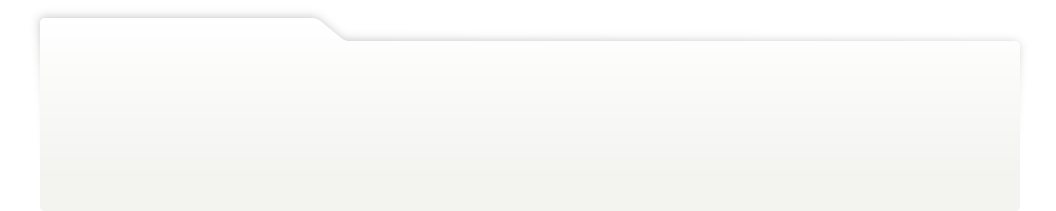
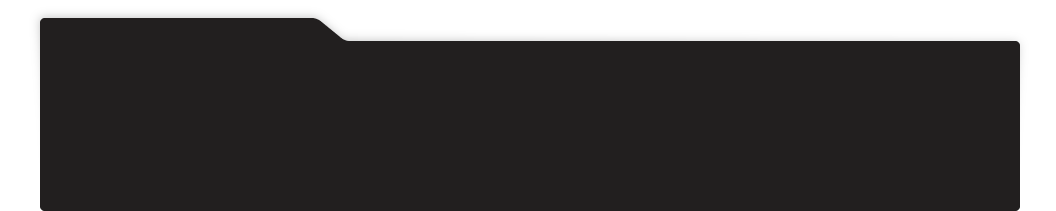
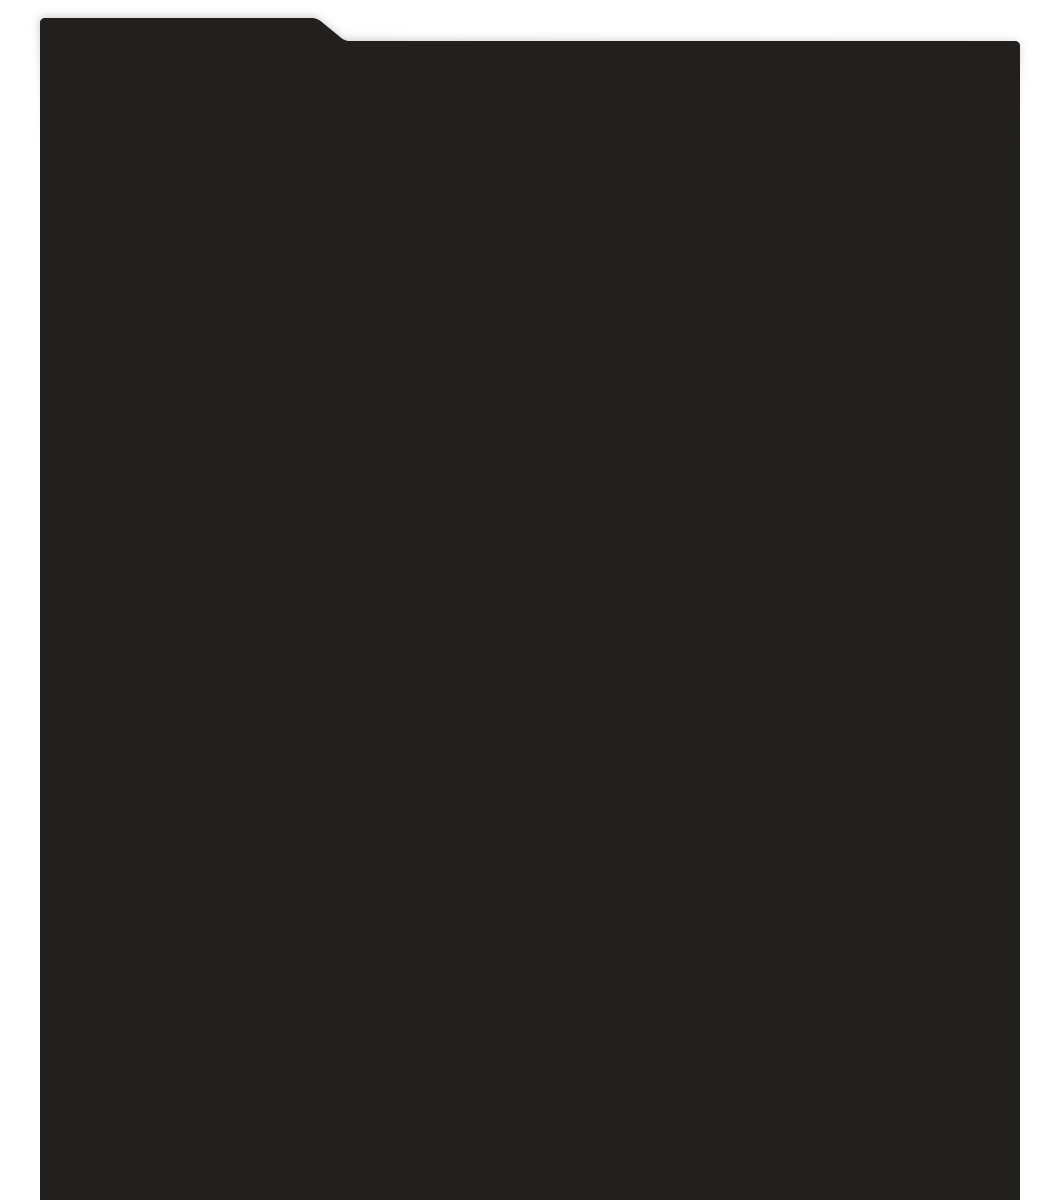
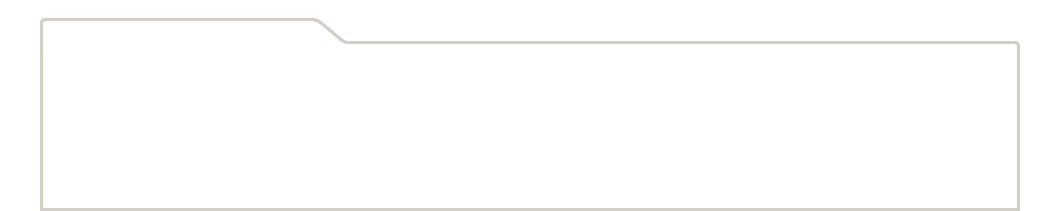
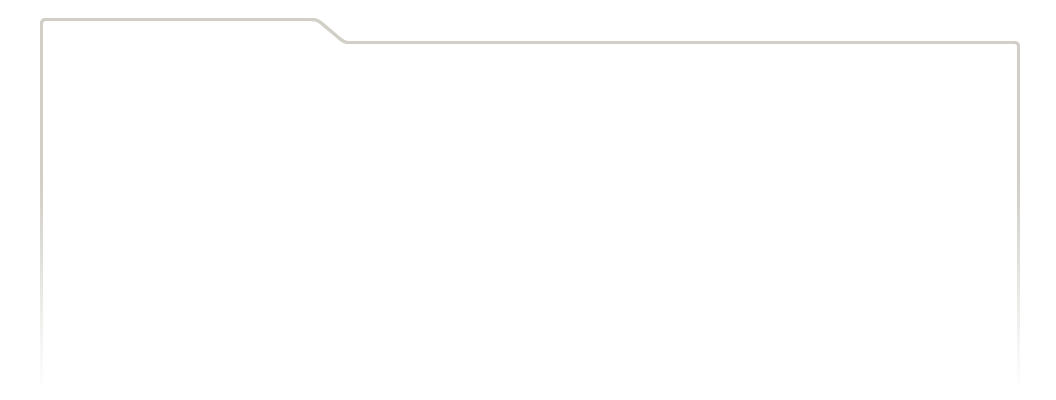
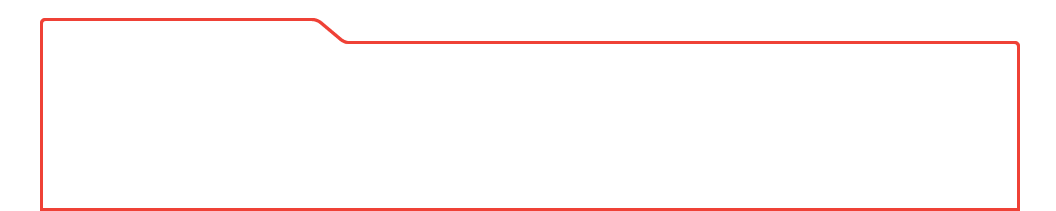
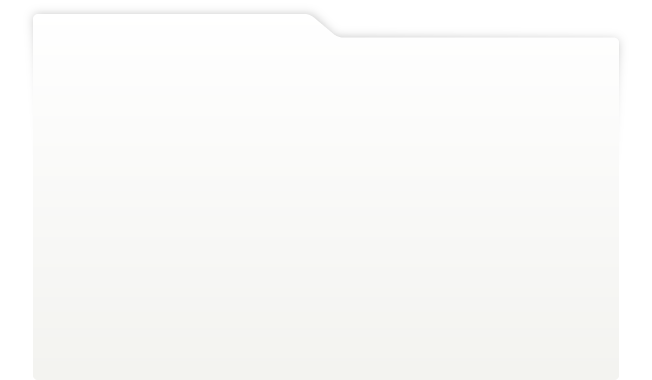
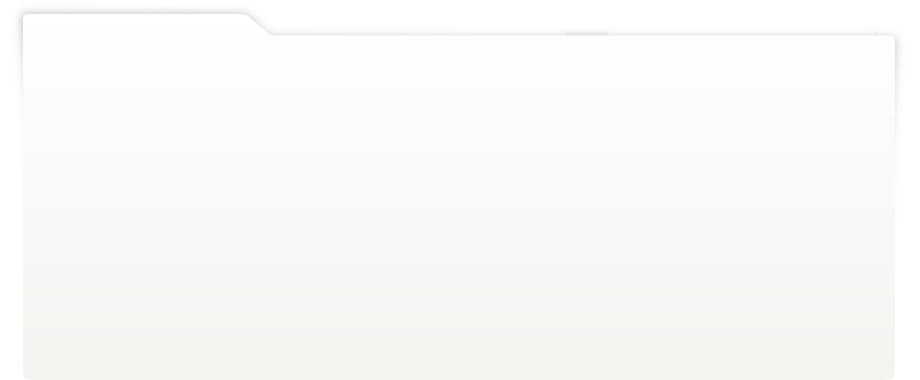
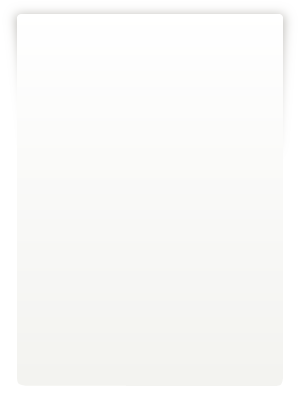
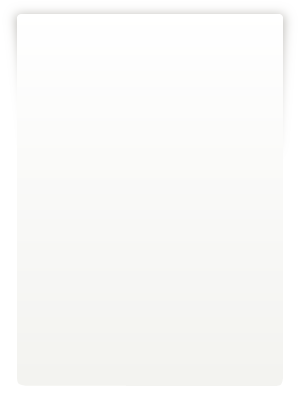
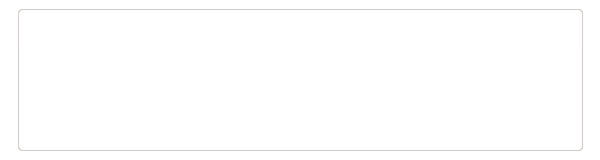
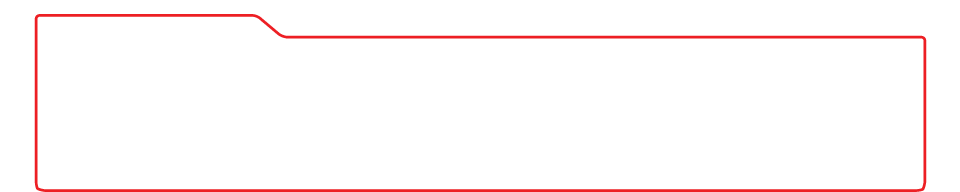
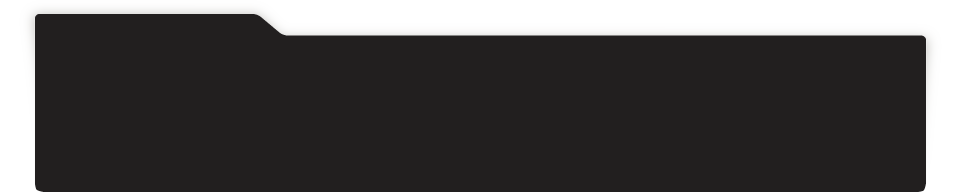
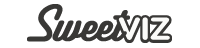
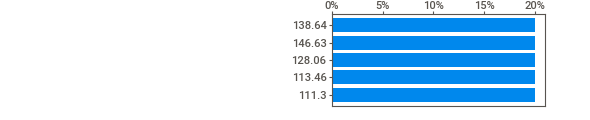
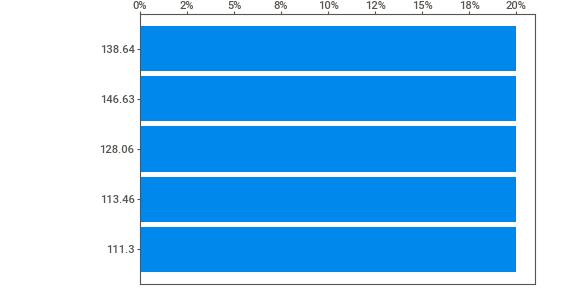
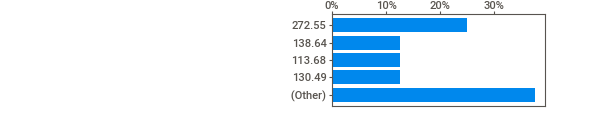
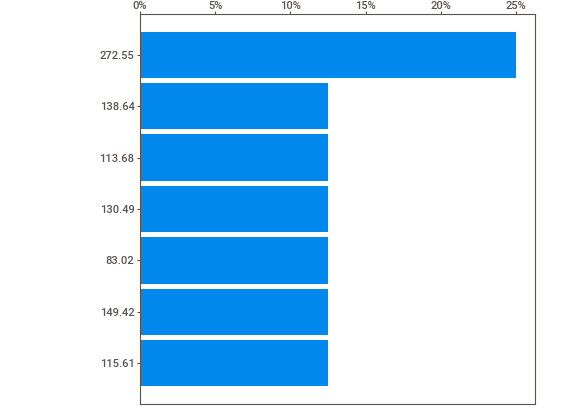
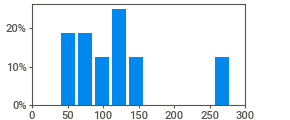
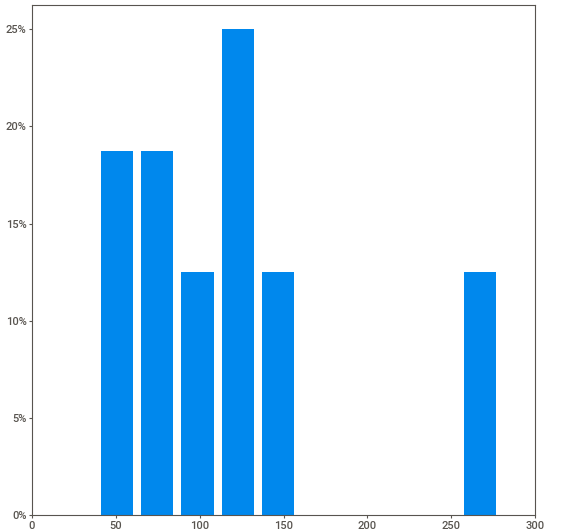
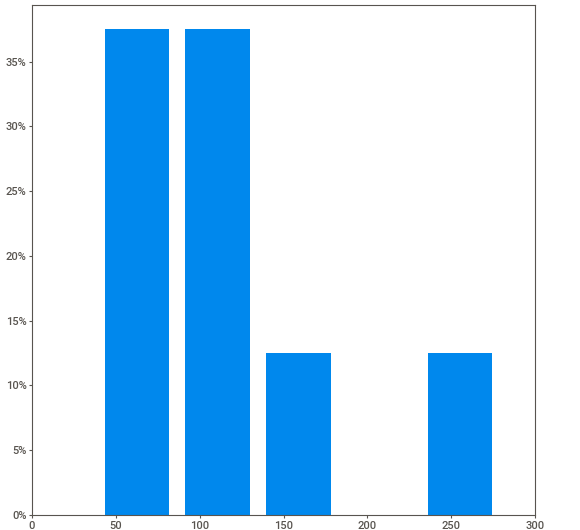
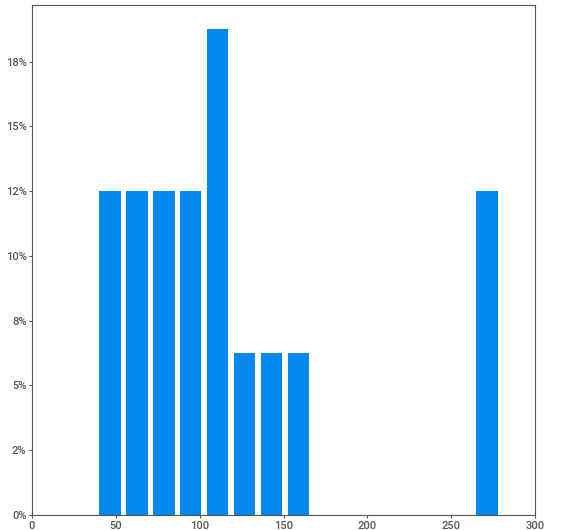
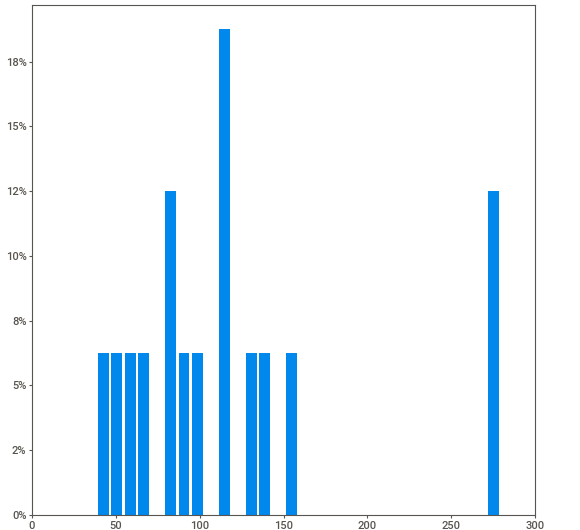
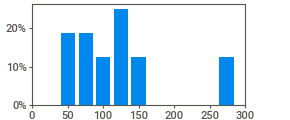
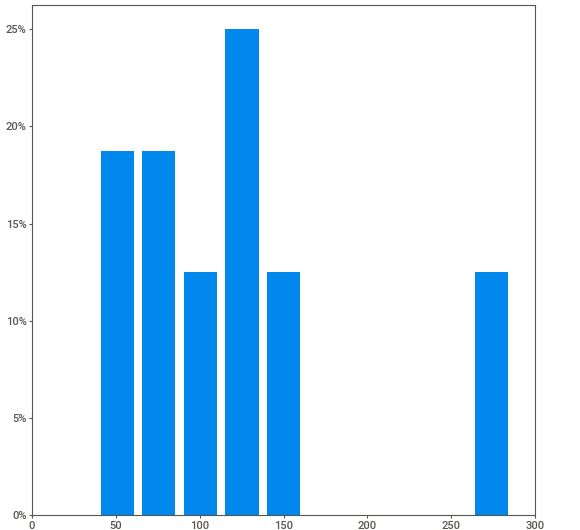
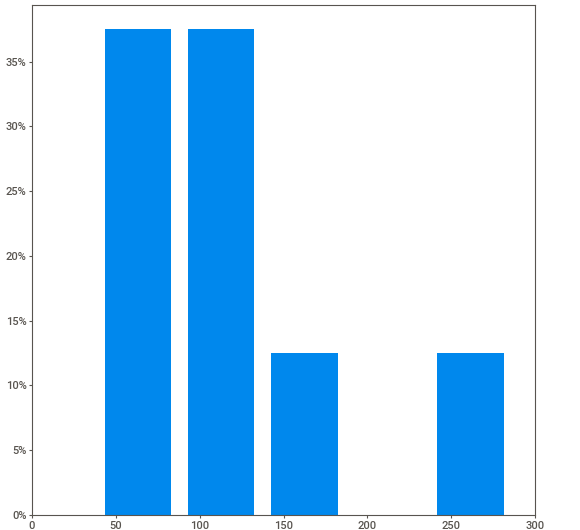
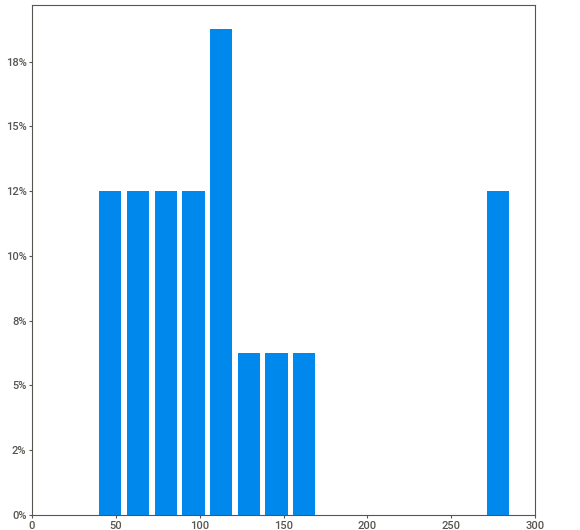
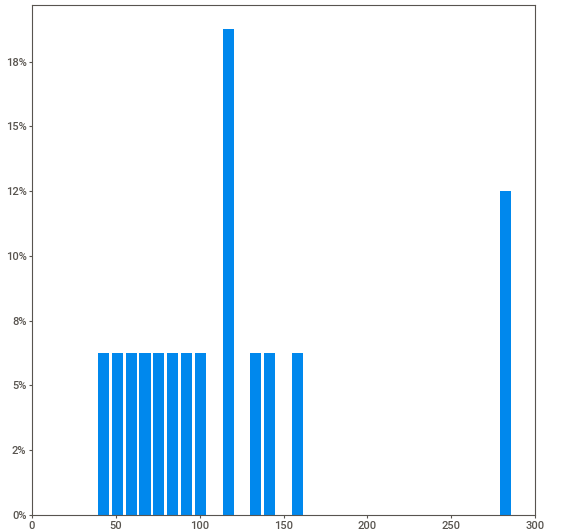
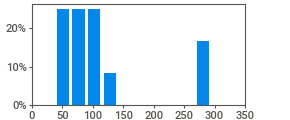
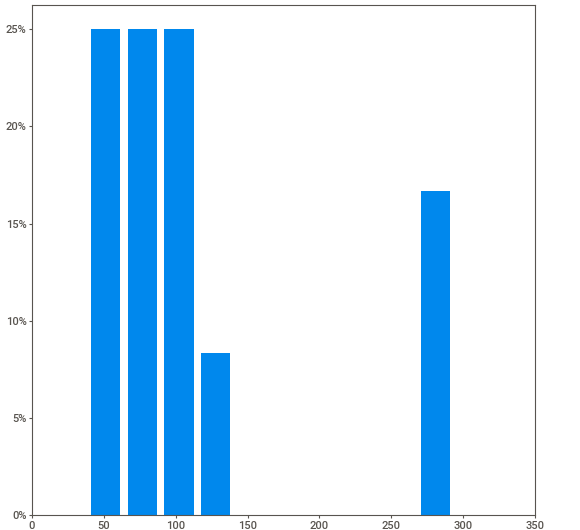
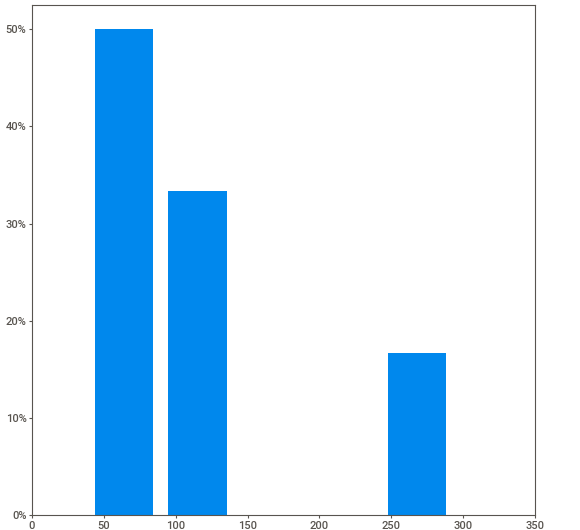
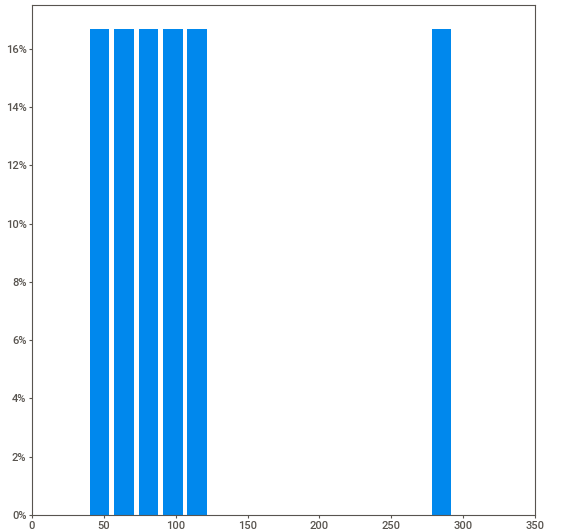
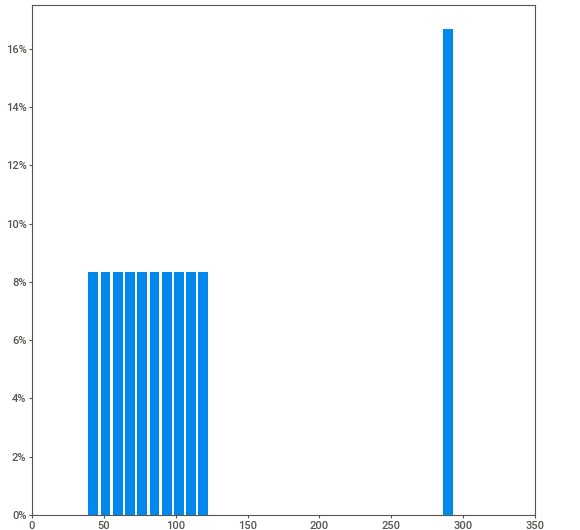
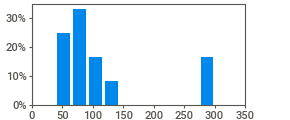
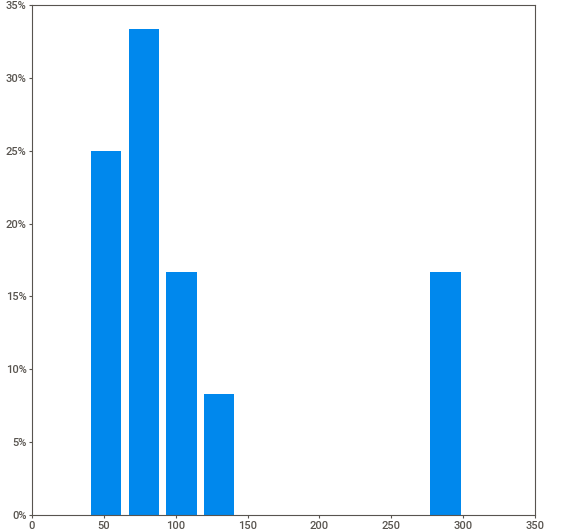
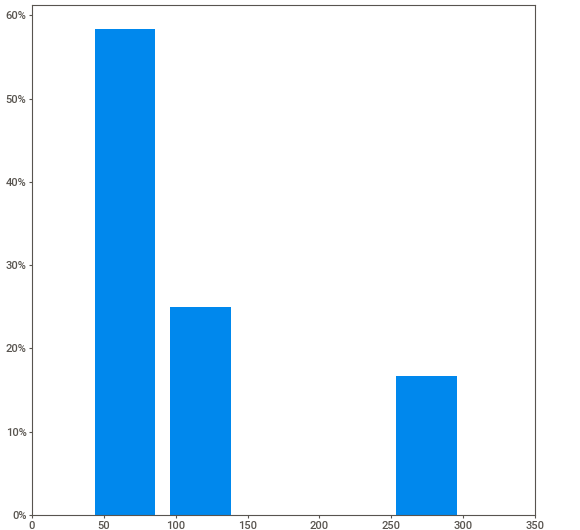
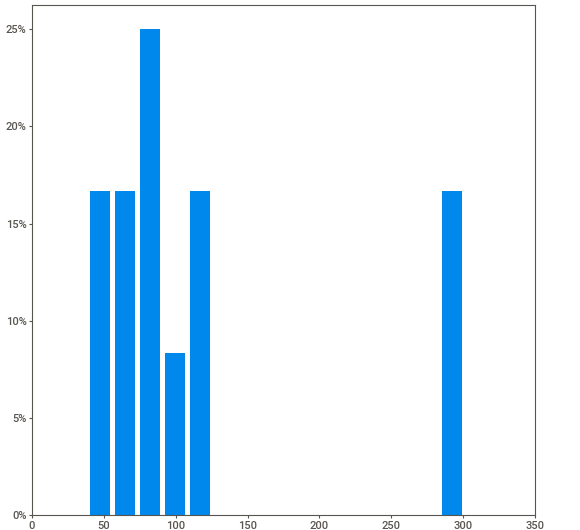
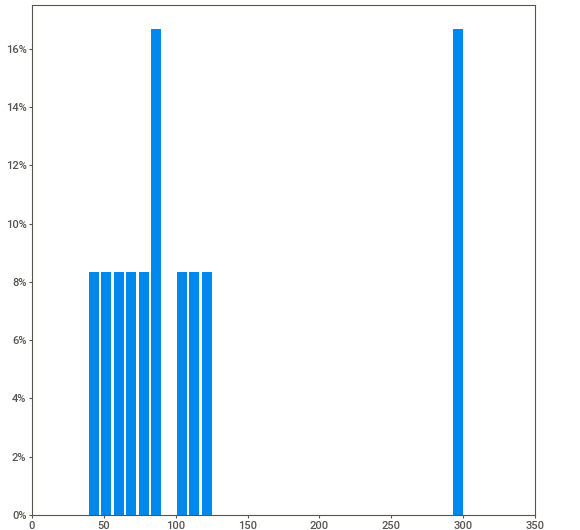
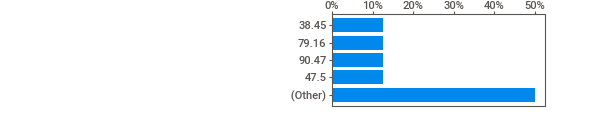
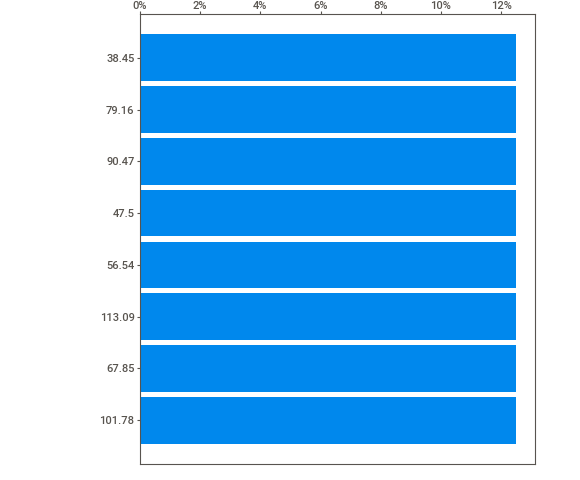
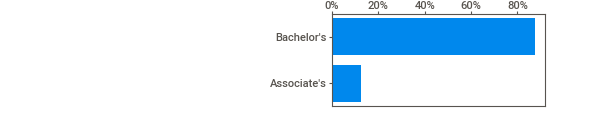
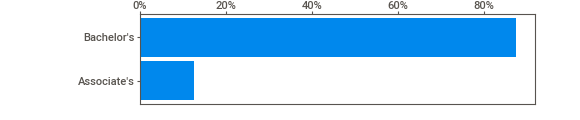
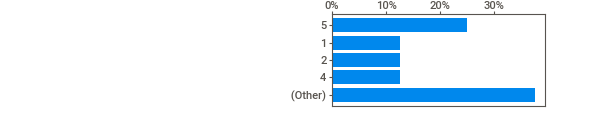
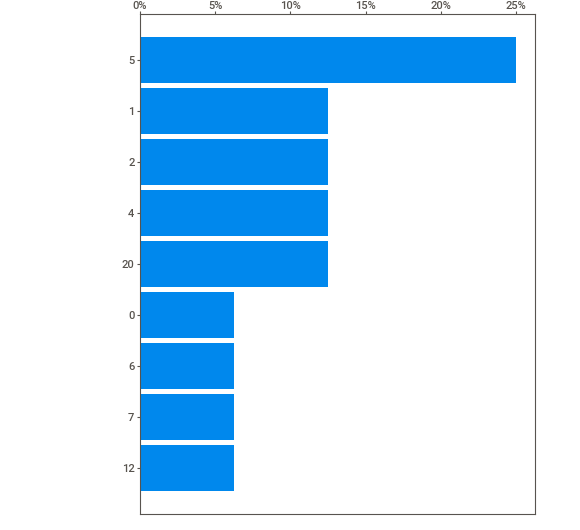
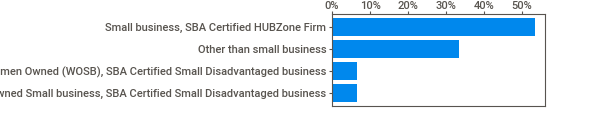
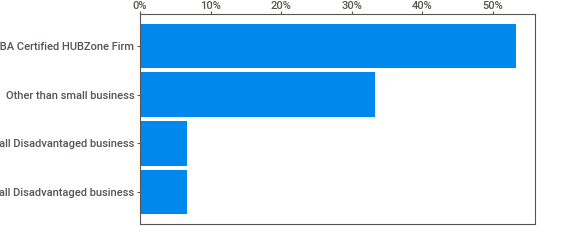
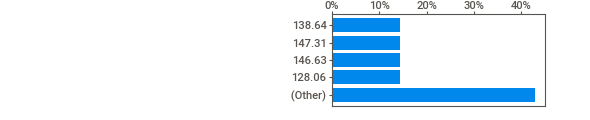
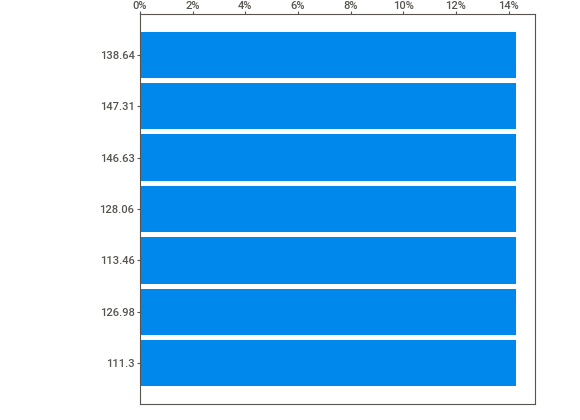
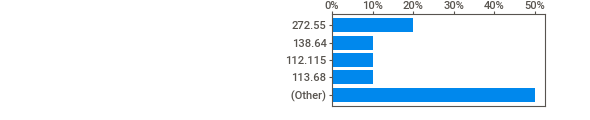
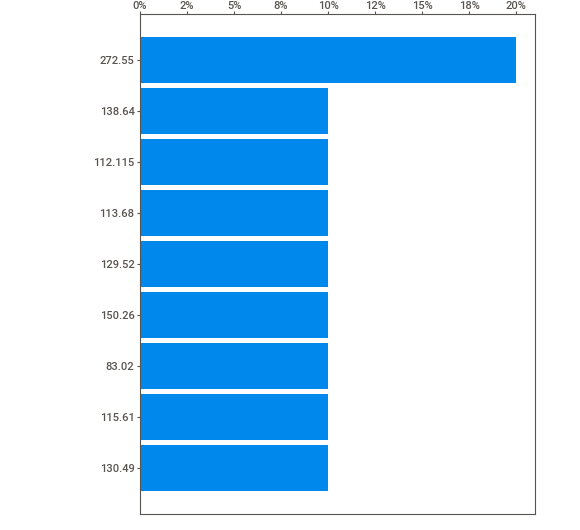
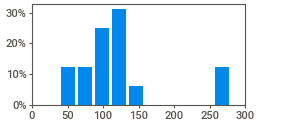
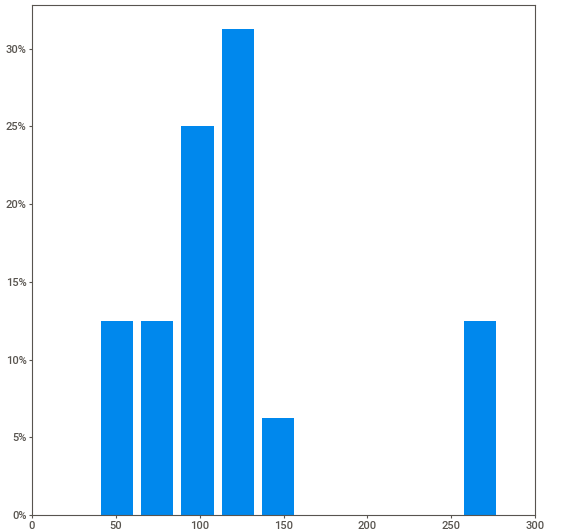
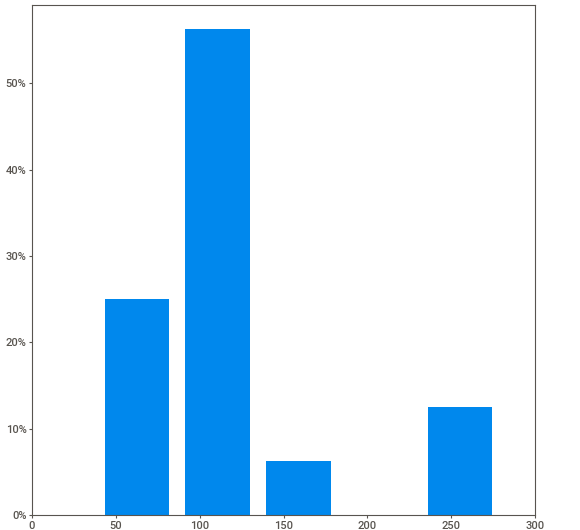
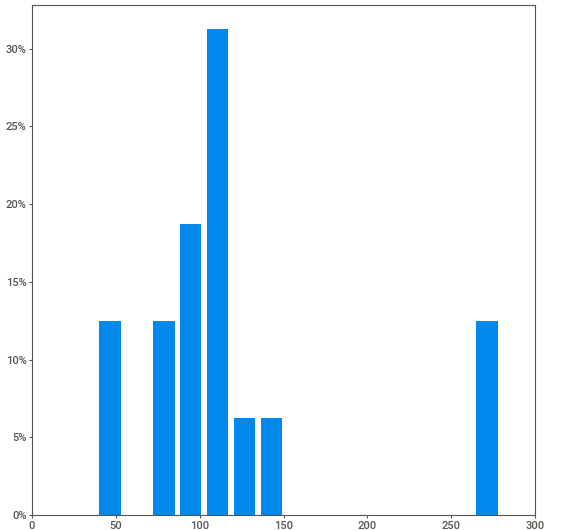
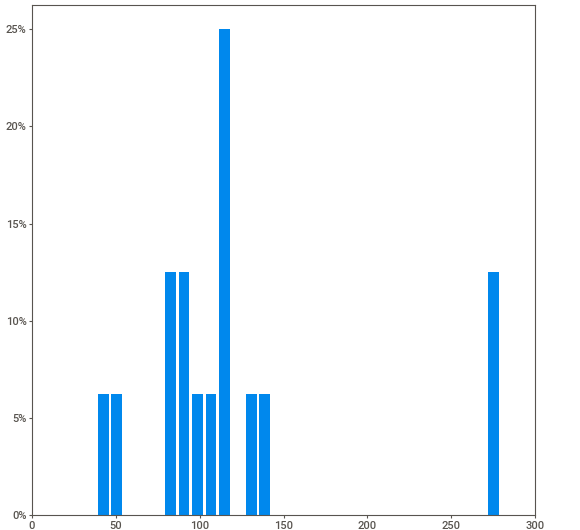
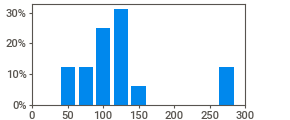
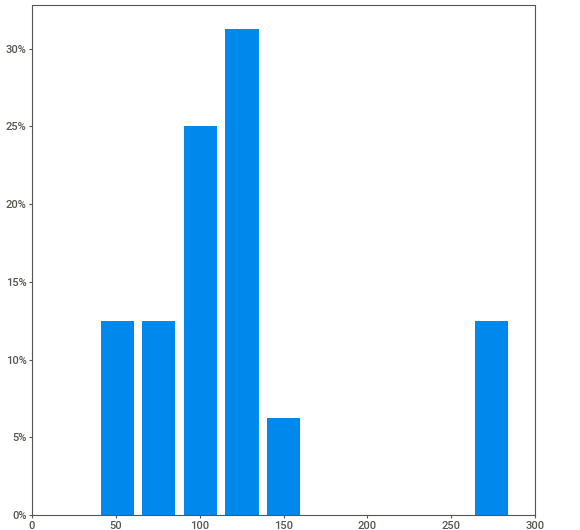
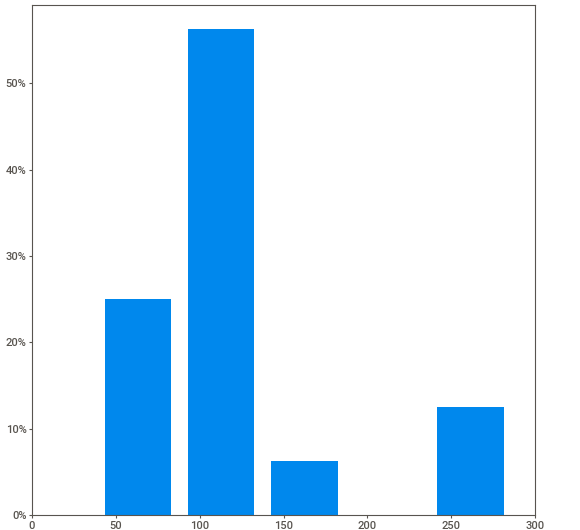
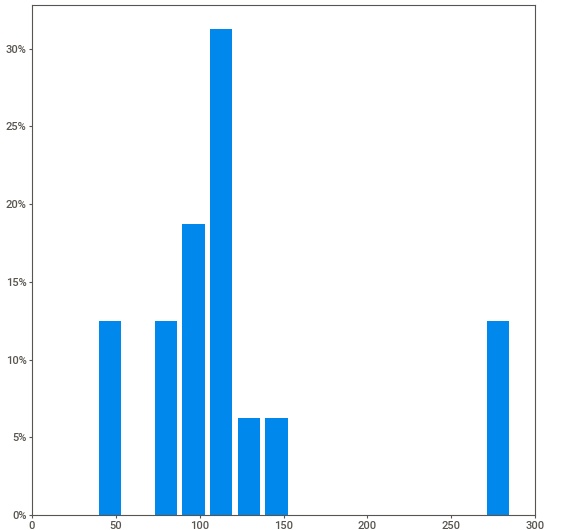
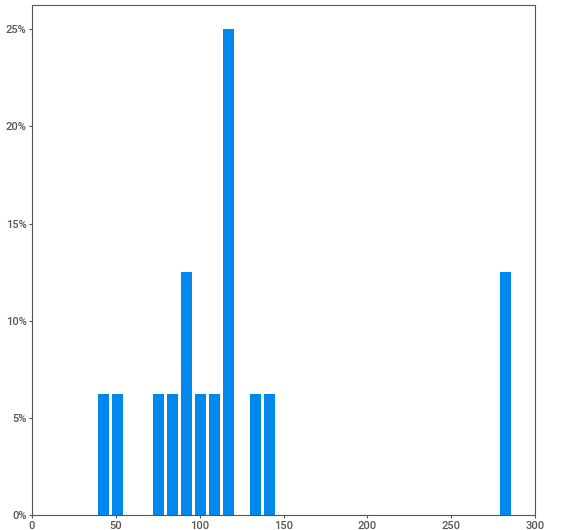
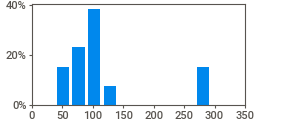
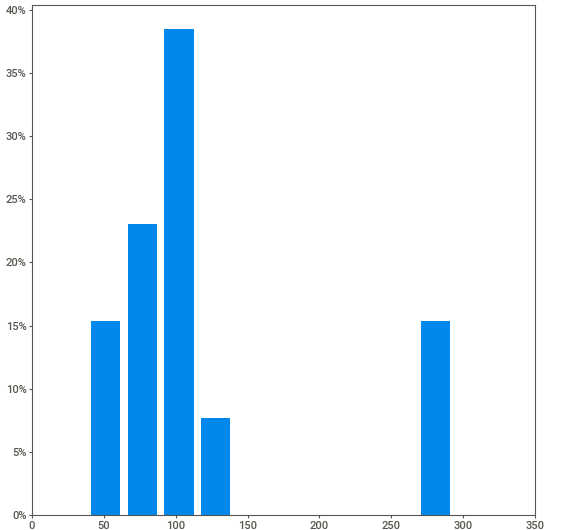
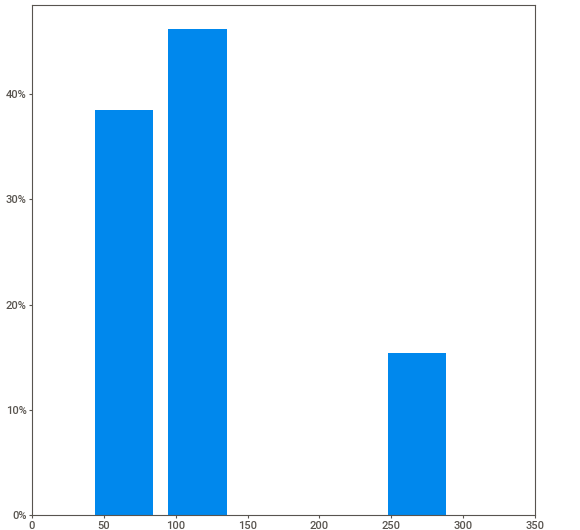
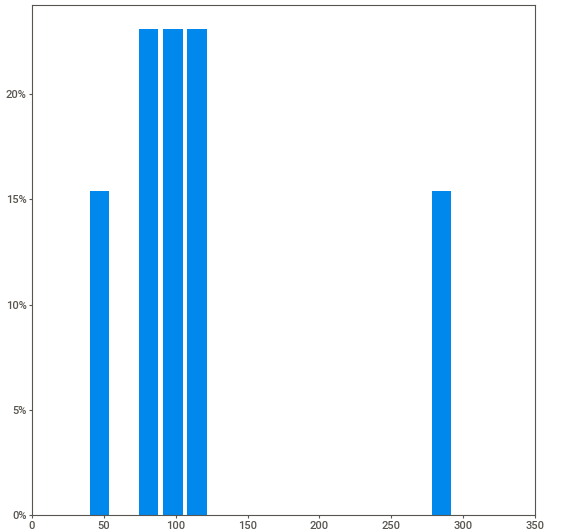
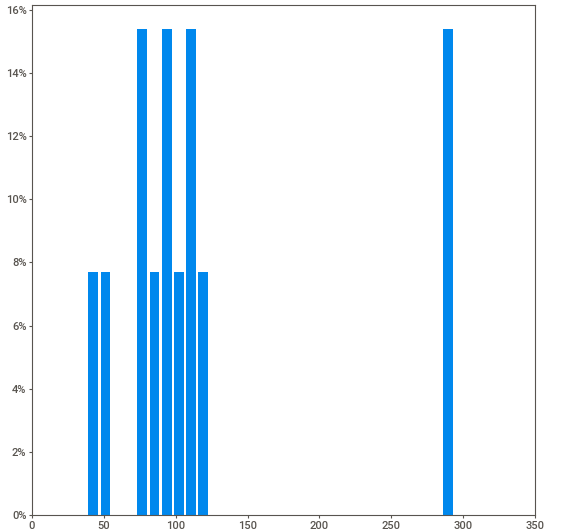
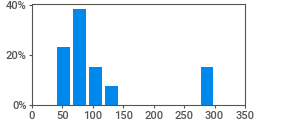
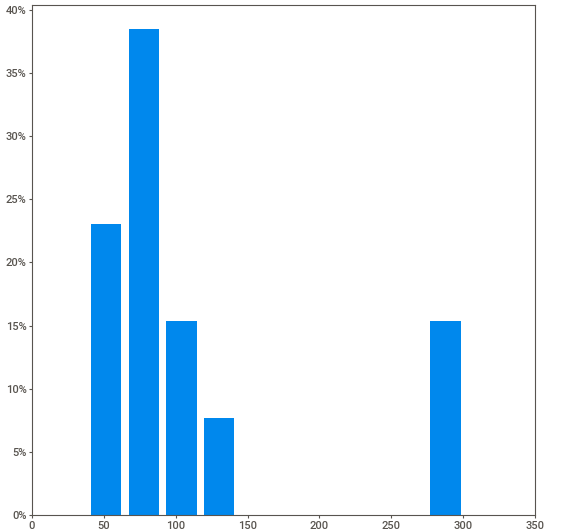
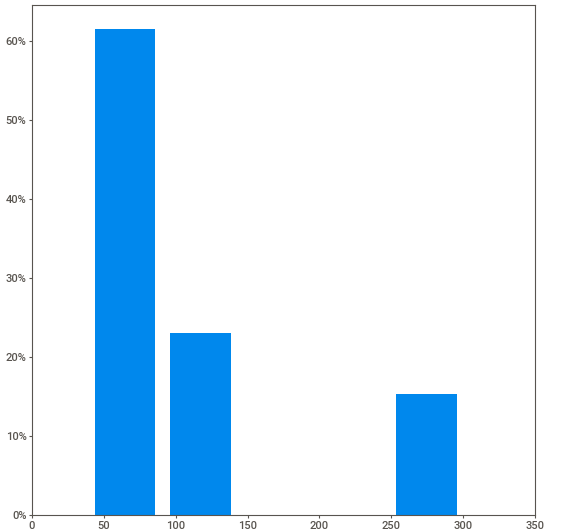
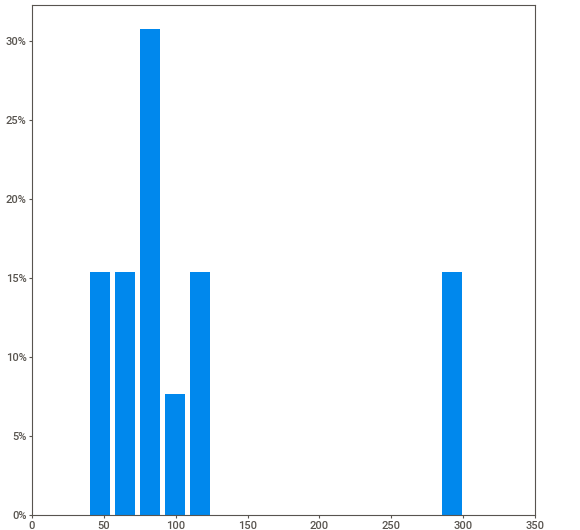
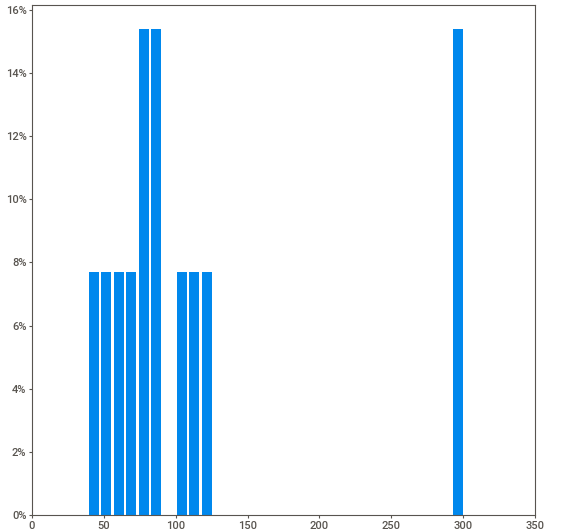
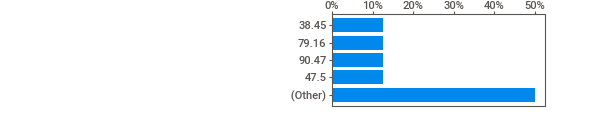
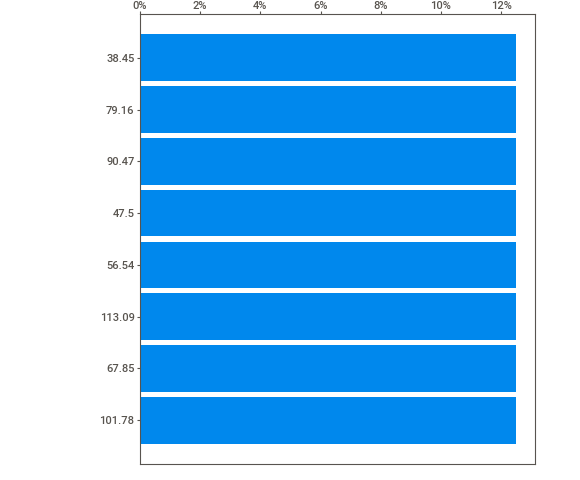
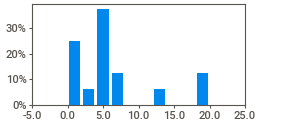
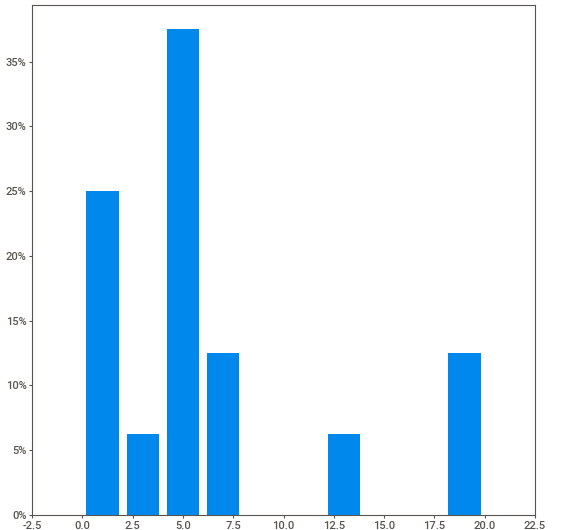
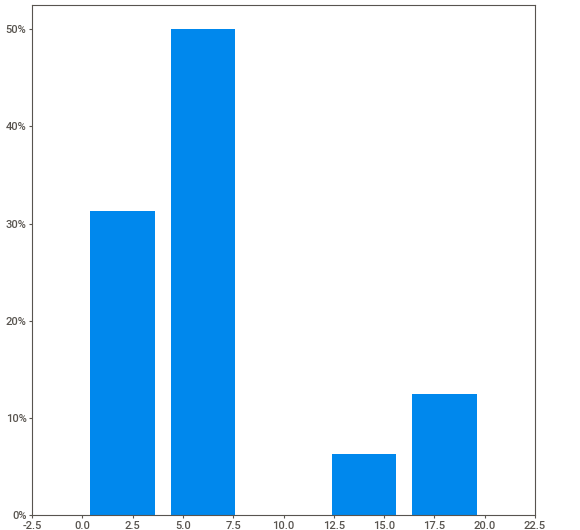
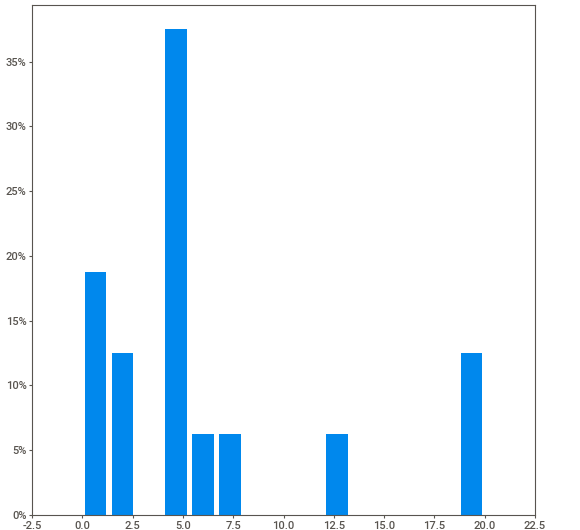
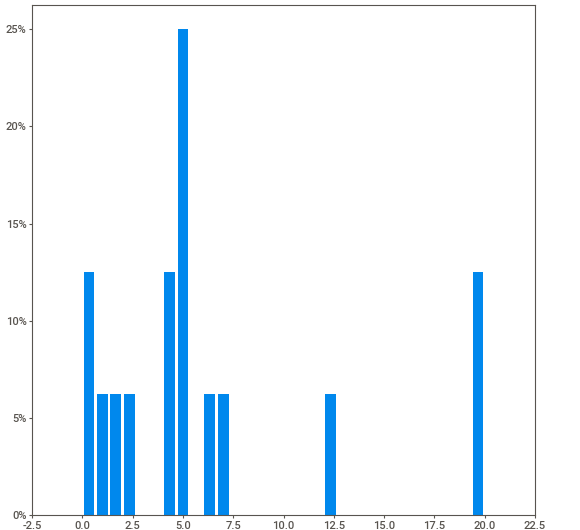
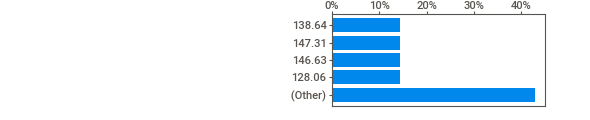
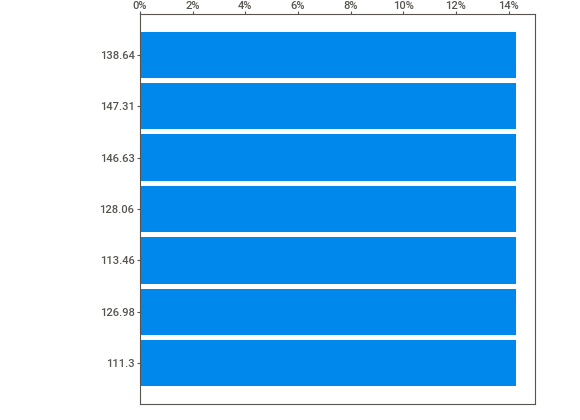
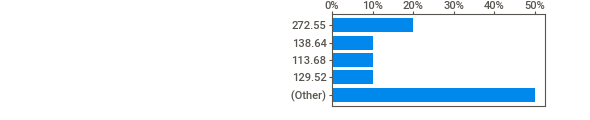
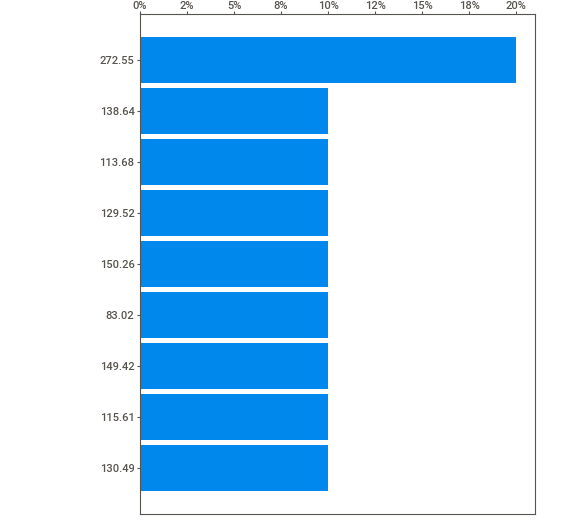
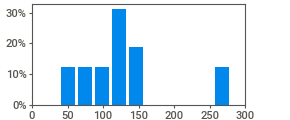
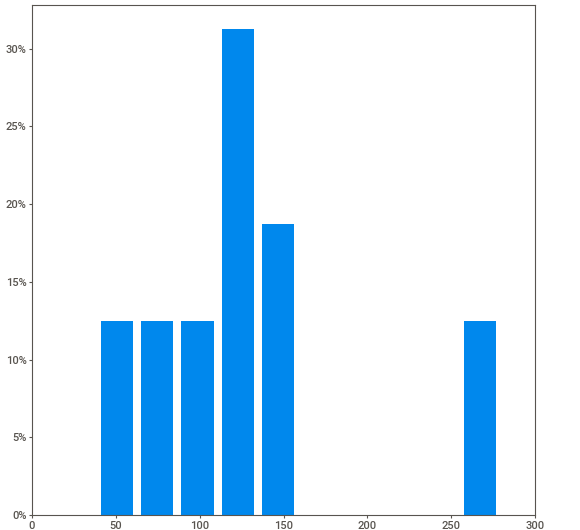
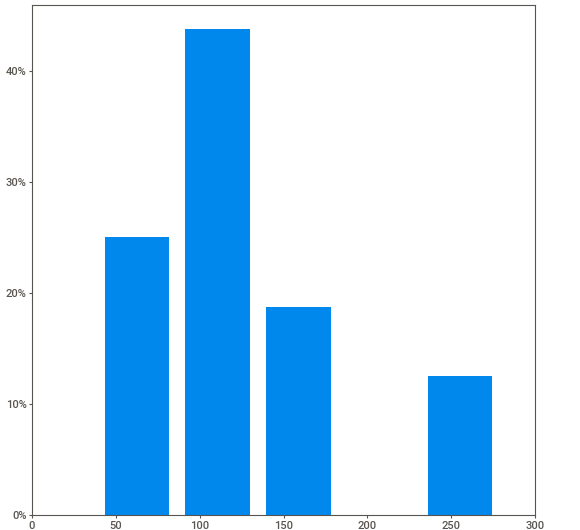
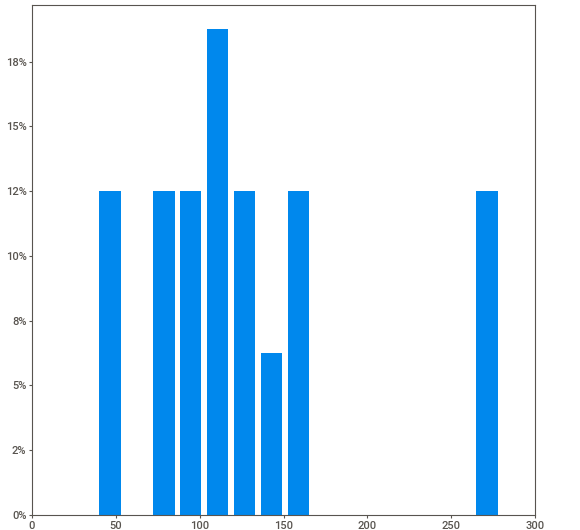
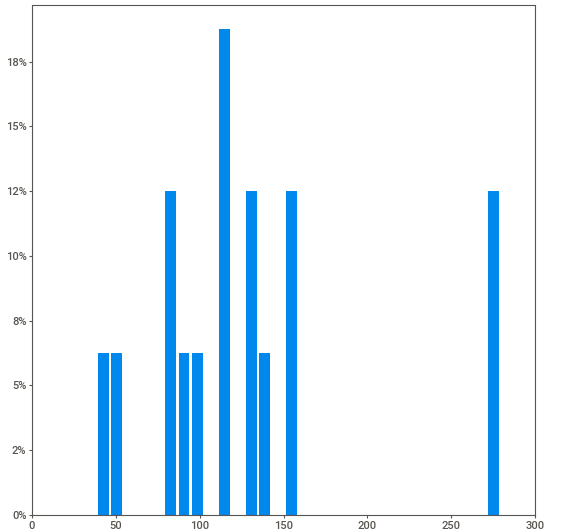
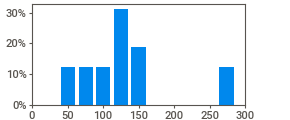
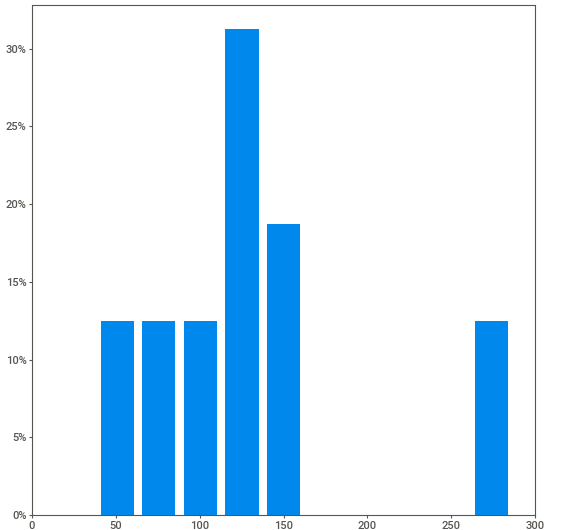
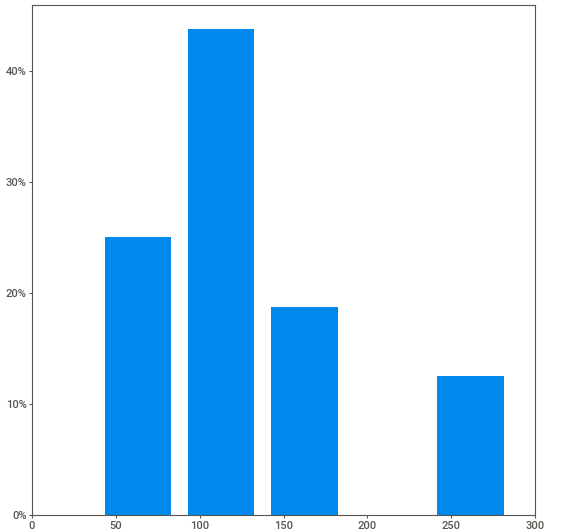
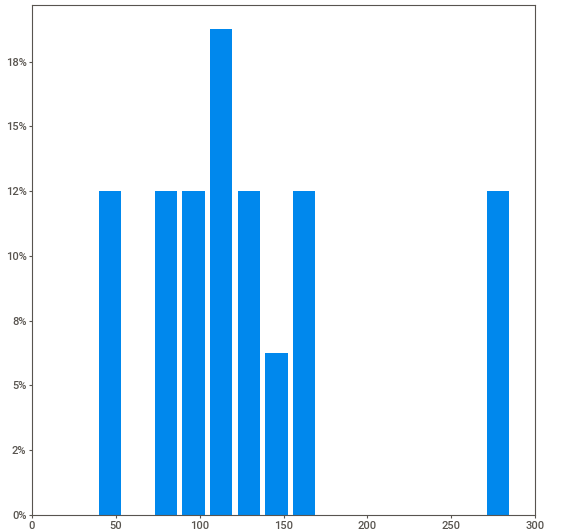
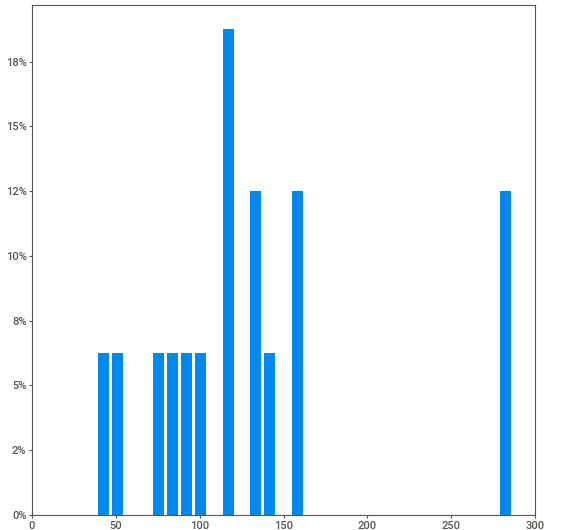
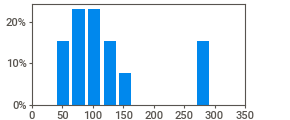
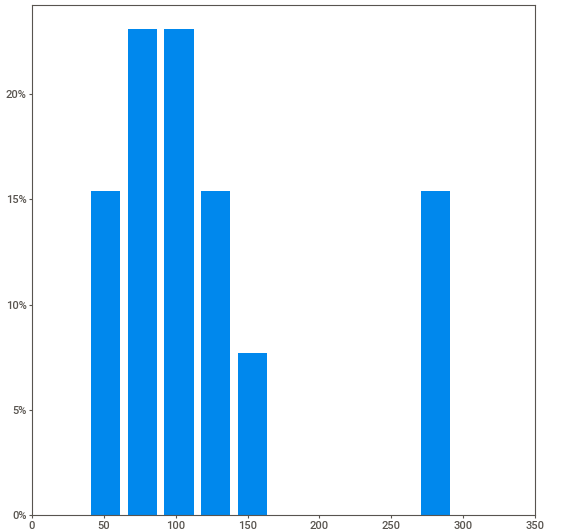
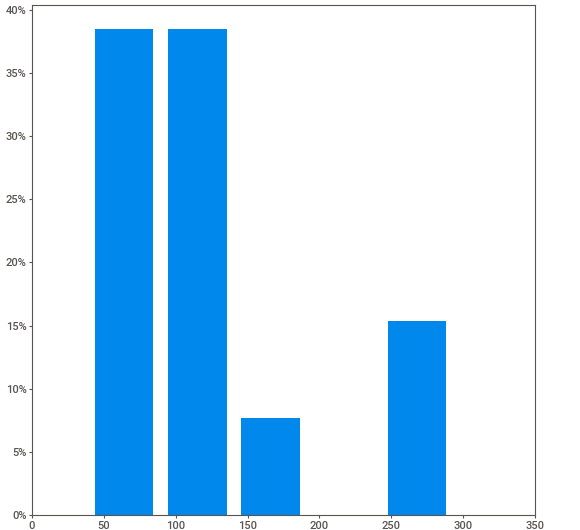
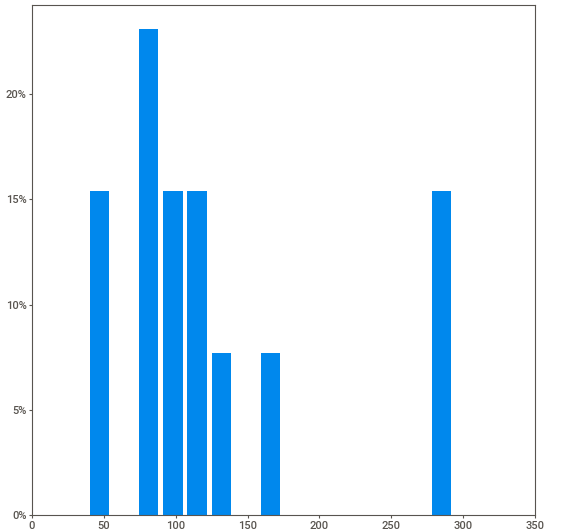
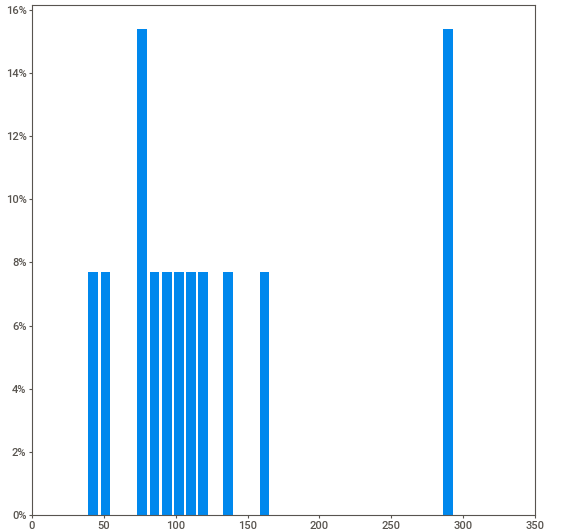
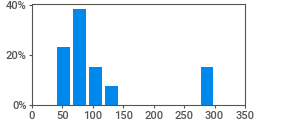
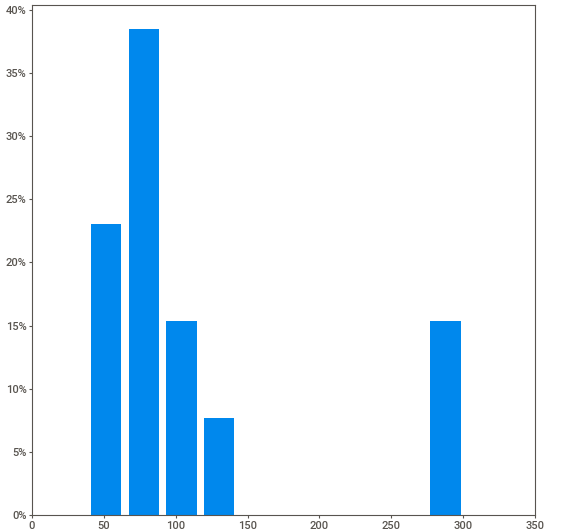
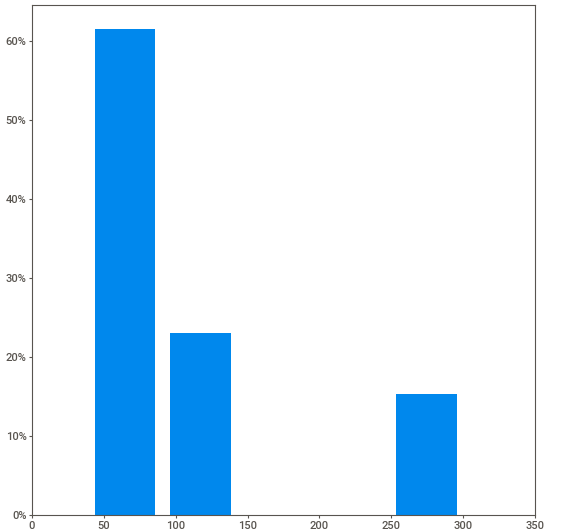
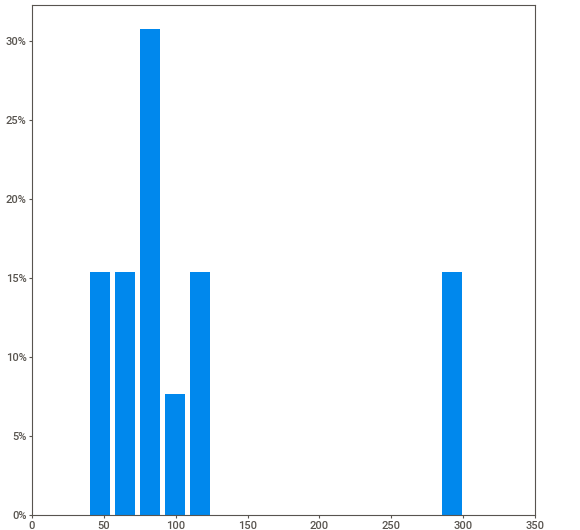
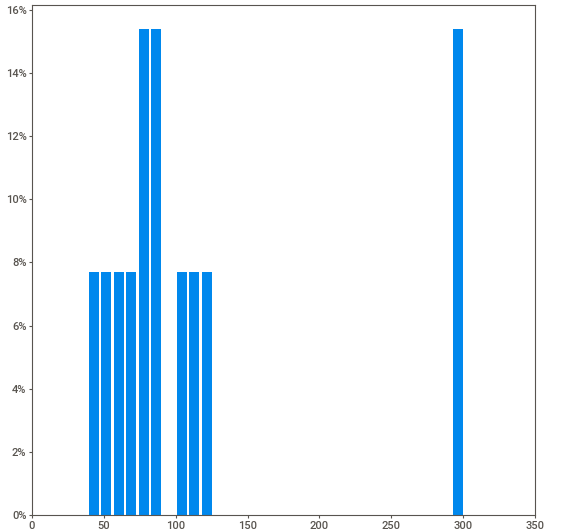
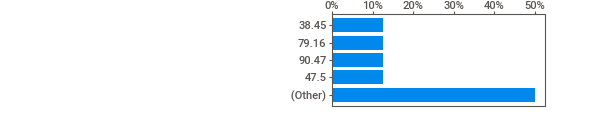
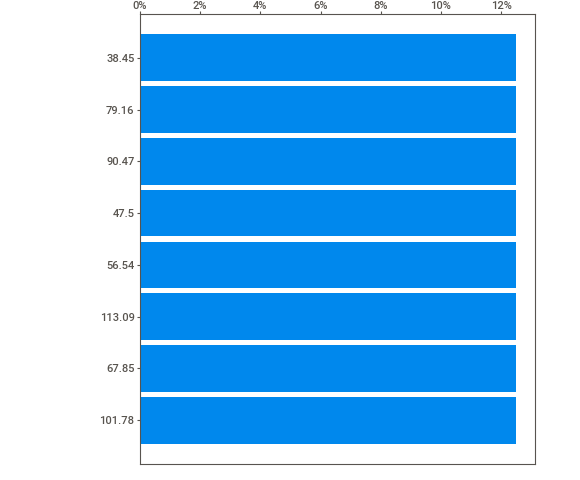
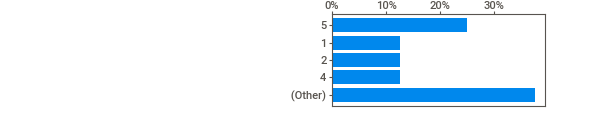
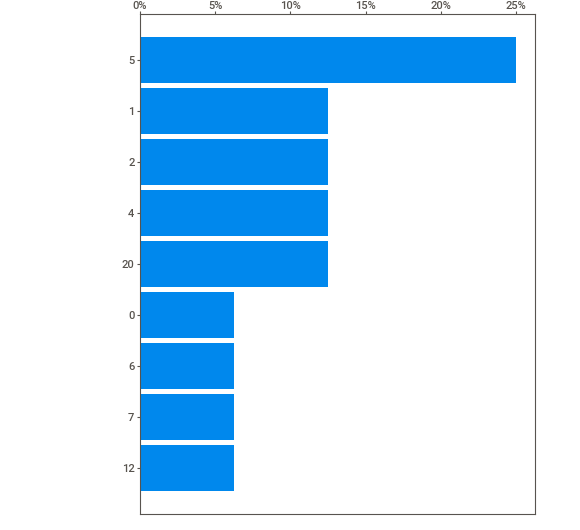
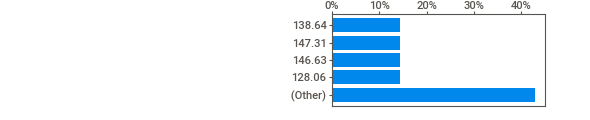
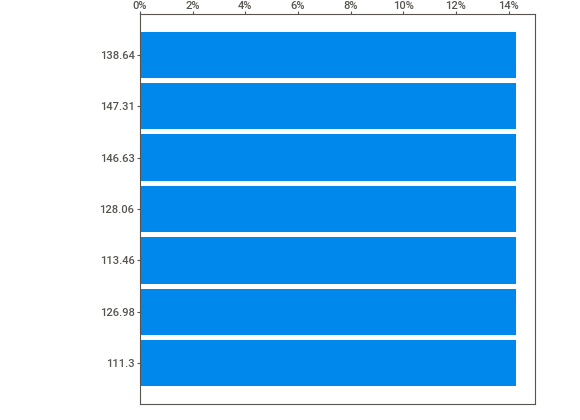
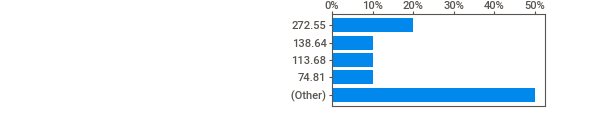
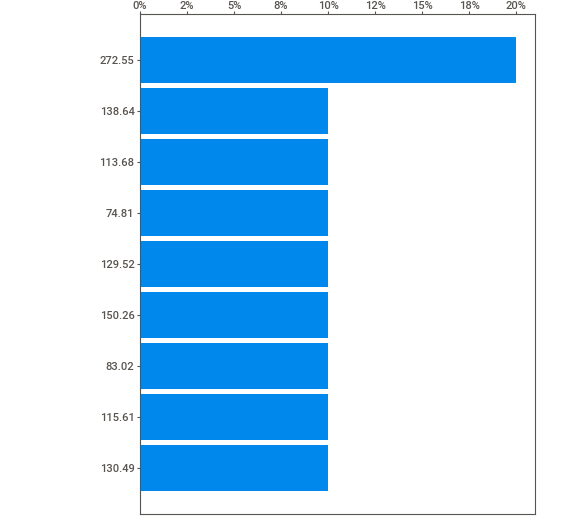
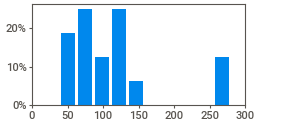
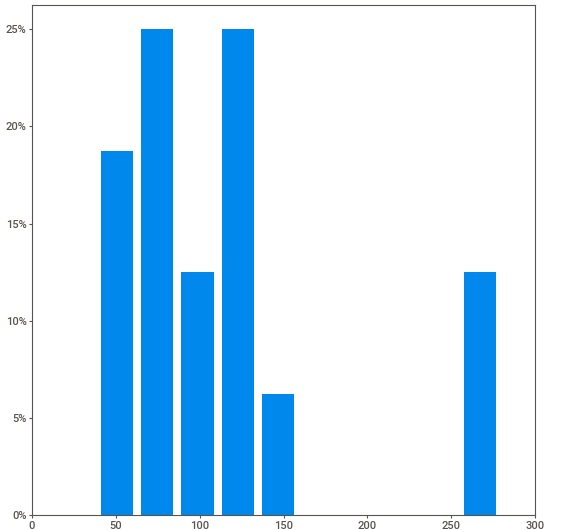
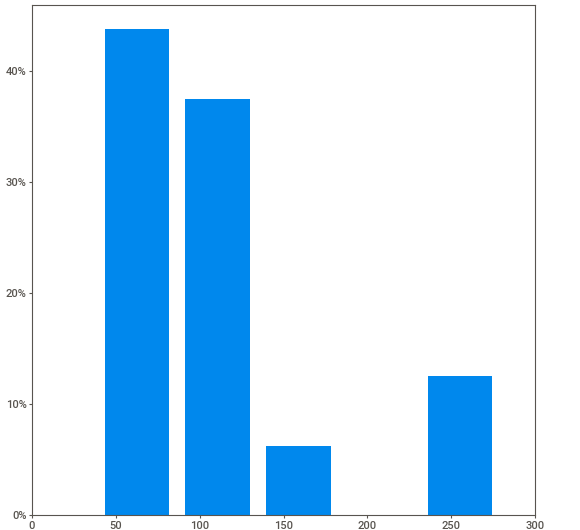
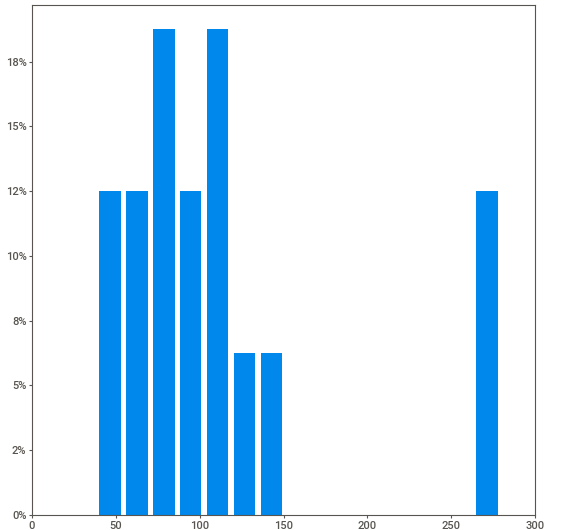
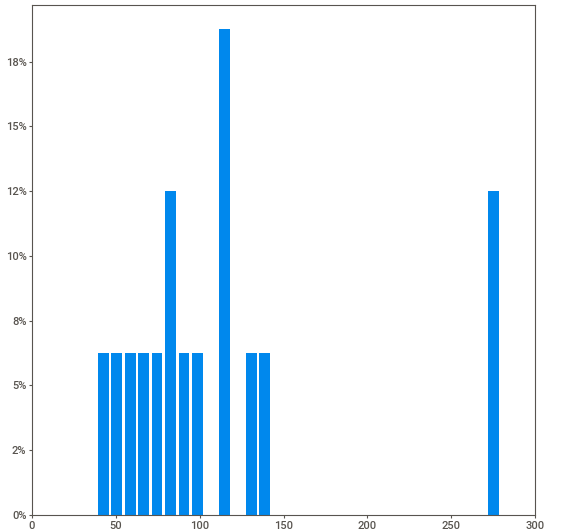
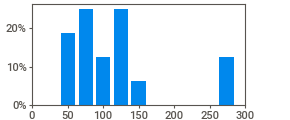
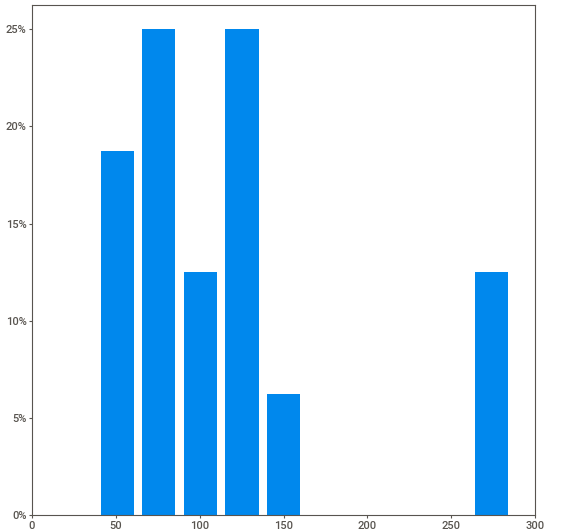
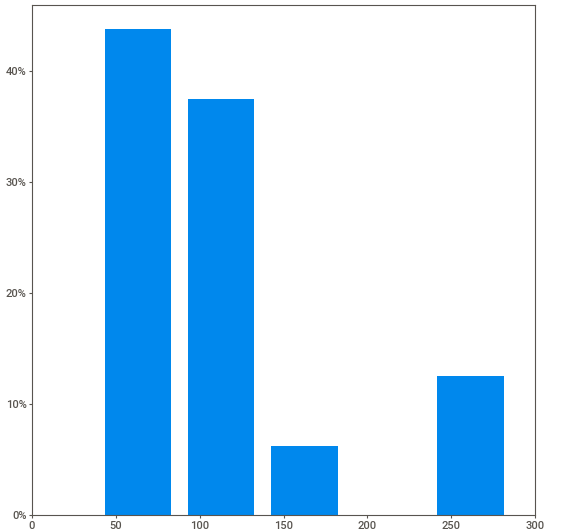
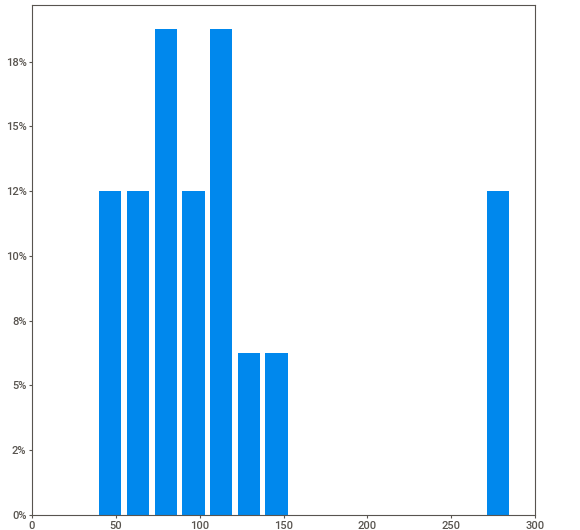
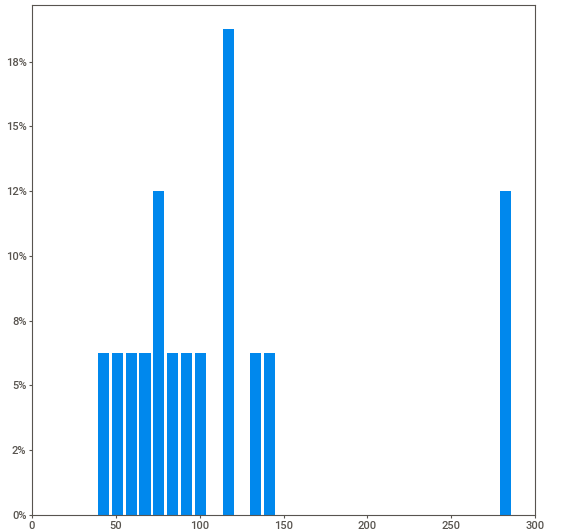
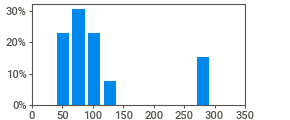
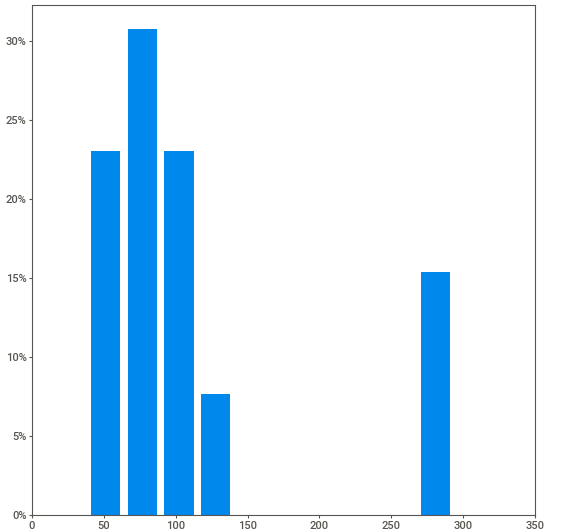
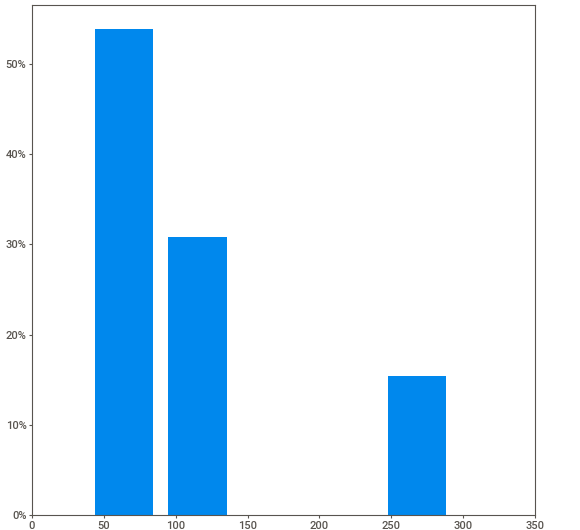
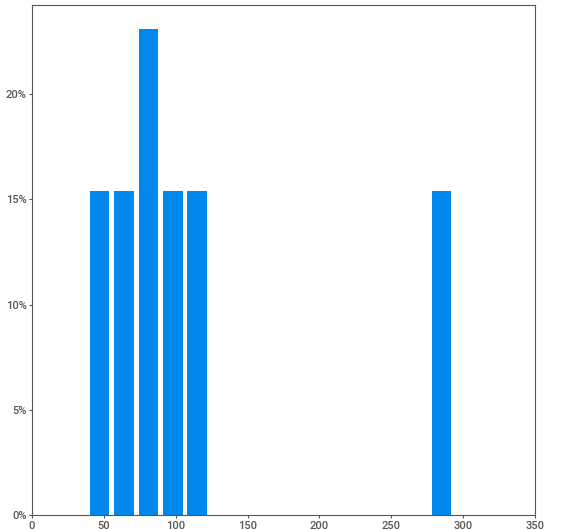
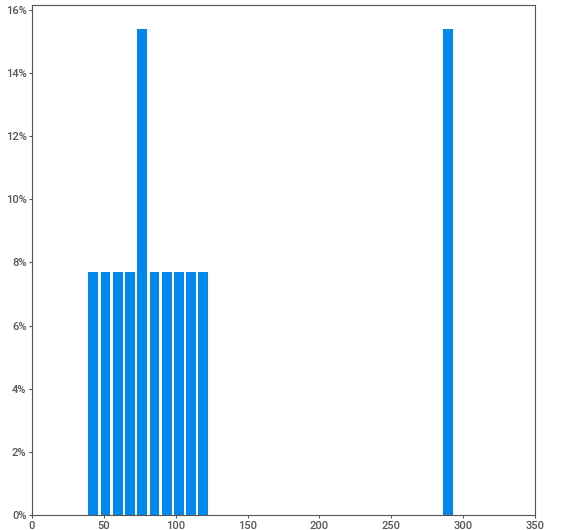
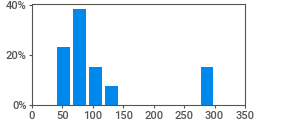
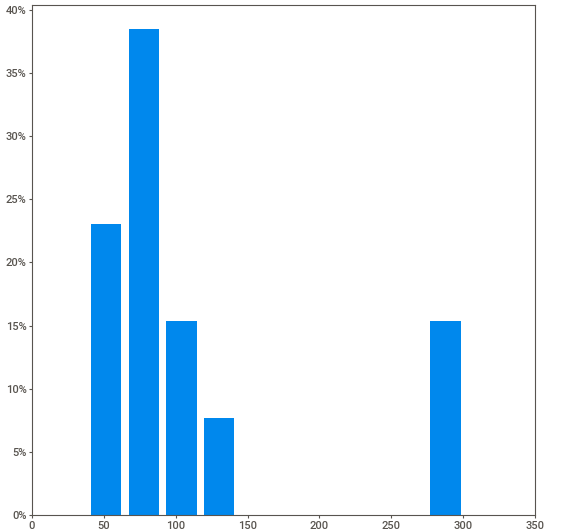
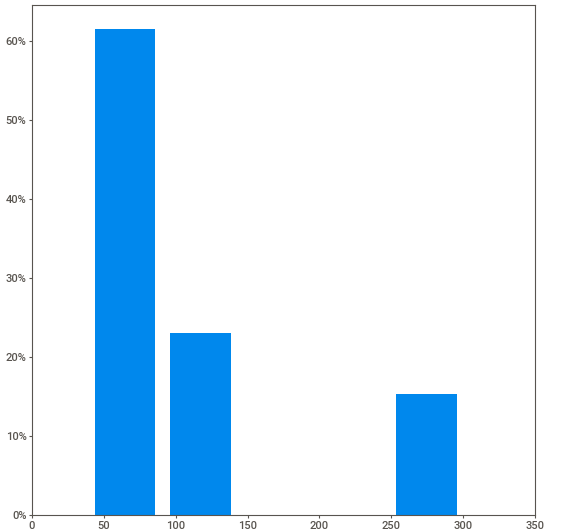
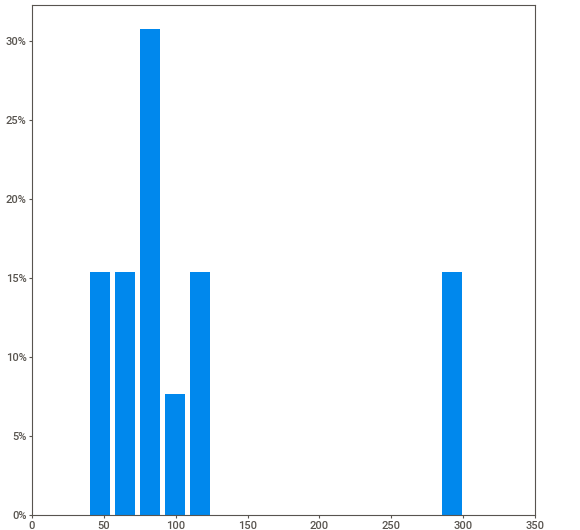
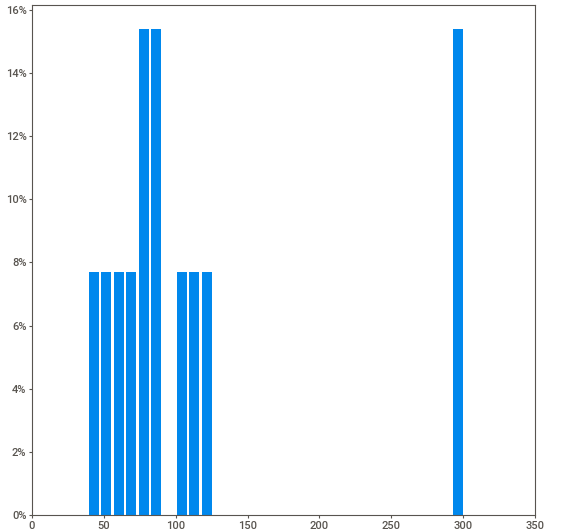
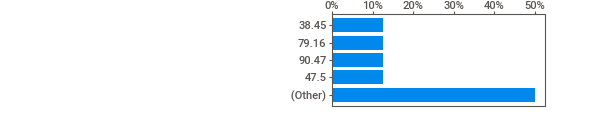
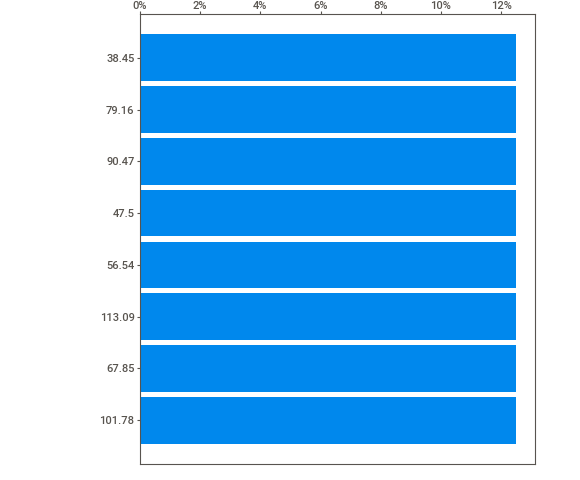
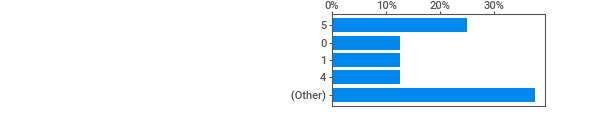
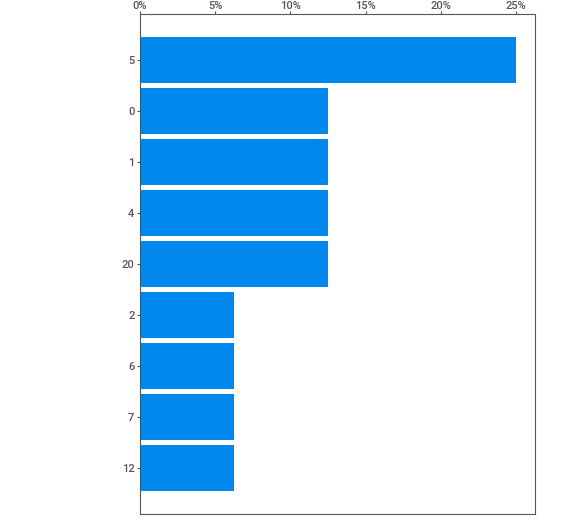
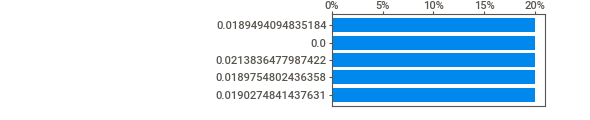
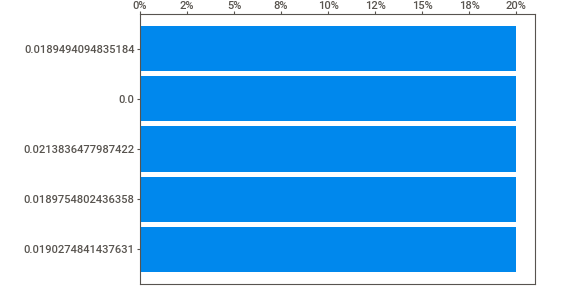
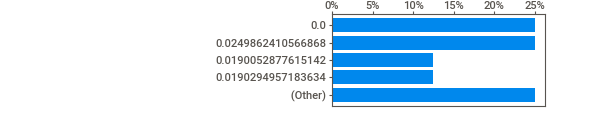
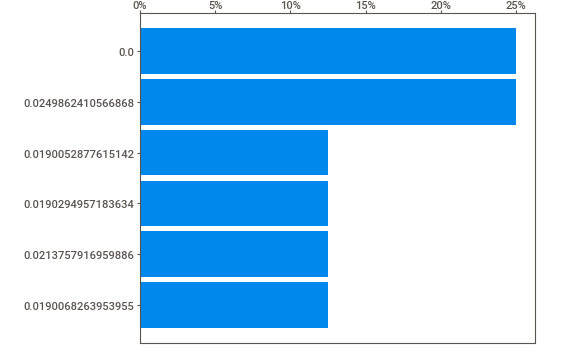
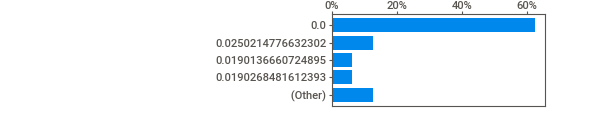
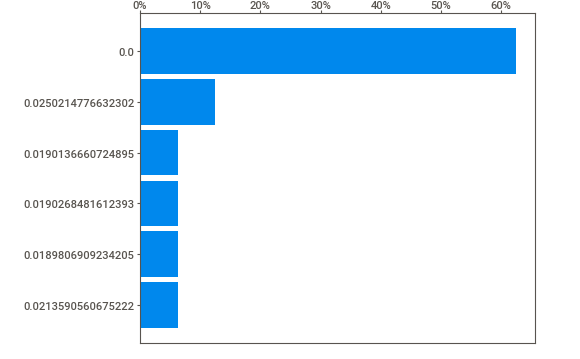
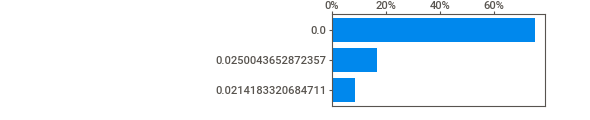
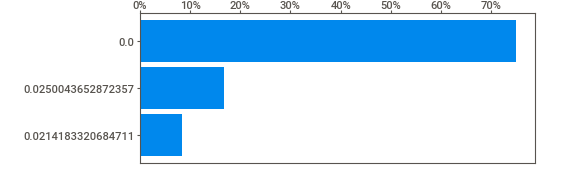
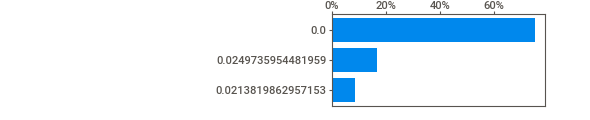
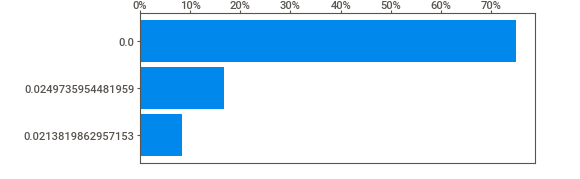
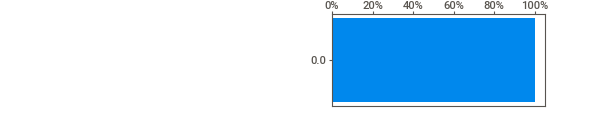
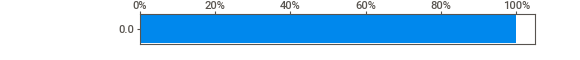
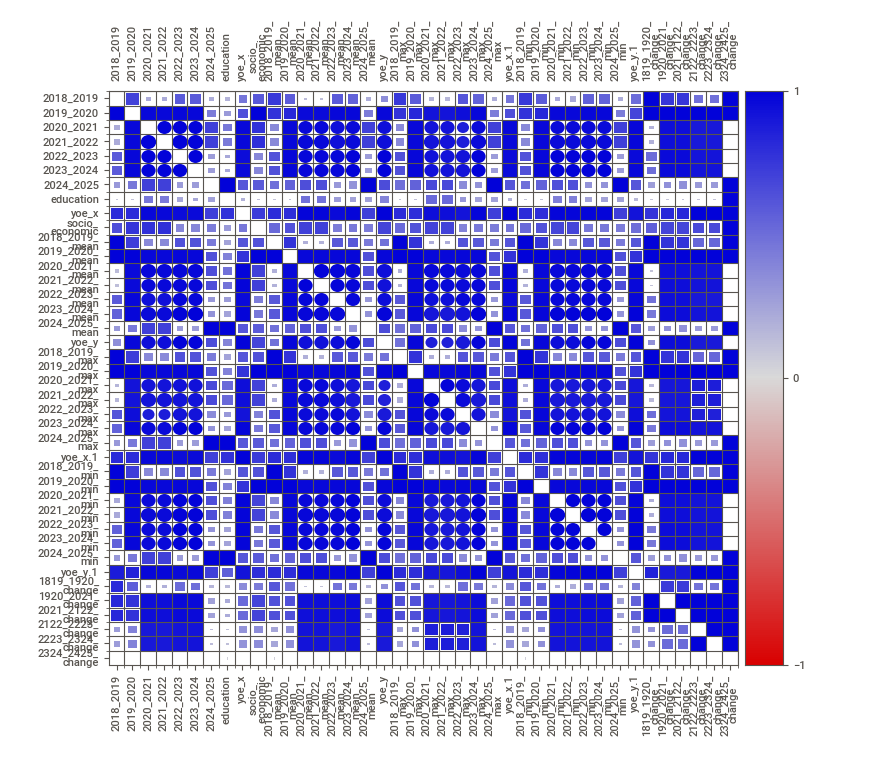
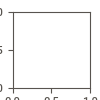

In [69]:
find_role('implement database security')

In [70]:
df2

,role,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,education,functional_responsibility,...,2023_2024_min,2024_2025_min,yoe_y.1,1819_1920_change,1920_2021_change,2021_2122_change,2122_2223_change,2223_2324_change,2324_2425_change,responsibility
196,Technical Team Leader 2,NaN,NaN,113.09,113.09,113.09,113.09,113.09,Bachelor's,A Technical Team Leader 2 guides other FTI pro...,...,113.09,113.09,5,NaN,NaN,0.000000,0.000000,0.000000,0.0,guides fti professional staff specify design d...
197,Technical Team Leader 1,NaN,NaN,101.78,101.78,101.78,101.78,101.78,Bachelor's,A Technical Team Leader 1 takes a supporting r...,...,101.78,101.78,5,NaN,NaN,0.000000,0.000000,0.000000,0.0,take support role plann supervis work fti prof...
198,Senior Software Engineer 2,NaN,NaN,90.47,90.47,90.47,90.47,90.47,Bachelor's,A Senior Software Engineer 2 guides others in ...,...,90.47,90.47,4,NaN,NaN,0.000000,0.000000,0.000000,0.0,guides other perform tasks analyz document cli...
199,Senior Software Engineer 1,NaN,NaN,79.16,79.16,79.16,79.16,79.16,Bachelor's,A Senior Software Engineer 1 takes a supportin...,...,79.16,79.16,4,NaN,NaN,0.000000,0.000000,0.000000,0.0,take support role analyz document client busin...
200,Software Engineer 2,NaN,NaN,67.85,67.85,67.85,67.85,67.85,Bachelor's,A Software Engineer 2 guides others in perform...,...,67.85,67.85,1,NaN,NaN,0.000000,0.000000,0.000000,0.0,guides other perform tasks analyz document cli...
201,Software Engineer 1,NaN,NaN,56.54,56.54,56.54,56.54,56.54,Bachelor's,A Software Engineer 1 takes a supporting role ...,...,56.54,56.54,0,NaN,NaN,0.000000,0.000000,0.000000,0.0,take support role analyz document client busin...
202,Associate Software Engineer 2,NaN,NaN,47.50,47.50,47.50,47.50,47.50,Associate's,An Associate Software Engineer 2 guides others...,...,47.50,47.50,1,NaN,NaN,0.000000,0.000000,0.000000,0.0,guides other perform tasks analyz document cli...
203,Associate Software Engineer 1,NaN,NaN,38.45,38.45,38.45,38.45,38.45,Associate's,An Associate Software Engineer 1 takes a suppo...,...,38.45,38.45,0,NaN,NaN,0.000000,0.000000,0.000000,0.0,take support role analyz document client busin...
264,Data Administrator,111.30,113.68,116.11,118.59,121.13,123.72,NaN,Bachelor's,Provides highly technical expertise and guidan...,...,123.72,NaN,6,0.021384,0.021376,0.021359,0.021418,0.021382,NaN,provide highly technical expertise guidance de...
419,Database Specialist III,138.64,138.64,138.64,138.64,NaN,NaN,NaN,Bachelor's,Provides highly technical expertise and guidan...,...,NaN,NaN,7,0.000000,0.000000,0.000000,NaN,NaN,NaN,provide highly technical expertise guidance de...
